# 0 导入第三方库

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gp
import glob

import time,datetime
import math
from pyproj import Transformer,CRS
from pykalman import KalmanFilter

from rdp import rdp
from shapely.geometry import LineString,Point
from shapely.ops import nearest_points
from leuvenmapmatching.map.inmem import InMemMap
from leuvenmapmatching.matcher.distance import DistanceMatcher

import random as rd
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from shapely import affinity
import scipy
import scipy.cluster.hierarchy as sch
import requests
from sklearn.metrics import silhouette_score
from geopy.distance import geodesic
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.cluster import DBSCAN
import networkx as nx
from networkx.algorithms import community

# 使matplotlib支持中文字体和负号
plt.rcParams['font.family']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 1 轨迹数据初探

## 1.1 数据清洗

In [2]:
# 数据读取
def get_track_points(filename): # 读取轨迹文件中的轨迹点
    lines = [] # 由于每行中的字段可能并不完整，无法直接对齐生成DataFrame，因此首先存放所有轨迹点
    with open(filename, 'rb') as f: # 先用二进制读入，下面再解码，比文本读入迷度更快
        for f_line in f:
            f_line = f_line.decode(encoding='mbcs').strip() # 解码，并用strip去掉换行符
            line = [item for item in f_line.split(',')] # 按照逗号分割字段
            lines.append(line)
    f.close()
    return lines

In [3]:
%%time
file = '实习一_开发环境配置与轨迹数据初探/data/raw/20181110_0.txt'
track_points = get_track_points(file)

Wall time: 3.28 s


In [4]:
print(track_points[0])

['31914', '2018-11-10 19:20:48', '114.149703', '30.645903', '178', '0', '空车', '定位', '运营', 'ACC关', '里程:74214.6', '温度:47℃']


In [17]:
# 数据清洗
def inter(a,b): # 判断是否相交
    return list(set(a)&set(b))

def align_points(lines): # 提取分析需要的字段，对齐轨迹点，并生成Data Frame
    # 原始轨迹数据中包含的异常内容大致如下所示，若发现新的异常值，可进行补充
    anomalies = ['超速报警', '补传', '定位故障', 'LED故障', '摄像头故障', 
                 '未定位', '溜车报警', '计价器故障', '紧急报警', '超速', 'ACC关']
    df = pd.DataFrame() # 新建一个数据框
    # 本次实习需要用到字段说明表里的前7个字段
    points = [line[:7] for line in lines if not inter(line,anomalies)]# 清理、对齐轨迹点
    df = df.append(points)
    # 定义表头如下
    df.columns = ['出租车ID', '定位时间', '经度', '纬度', '方向', '速度', '空车/重车']
    return df

In [18]:
%%time
df = align_points(track_points)

Wall time: 2.19 s


In [19]:
print(df.head(20))

    出租车ID                 定位时间          经度         纬度   方向  速度 空车/重车
0   35335  2018-11-10 19:20:46  114.328292  30.497772  284  44    重车
1   35442  2018-11-10 19:20:48  114.344972  30.600098   38  52    空车
2   14075  2018-11-10 19:20:47  114.258847  30.590392  346  42    空车
3    1176  2018-11-10 19:20:48  114.263968  30.540418  266  55    重车
4     299  2018-11-10 19:20:48  114.312773  30.548415  170  42    重车
5   31275  2018-11-10 19:20:48  114.185158  30.616193  282  21    重车
6     126  2018-11-10 19:20:48  114.271547   30.65794   40  43    重车
7     382  2018-11-10 19:20:48  114.278592  30.620782  274  28    重车
8     932  2018-11-10 19:20:48  114.283837  30.602563  146  39    重车
9    8796  2018-11-10 19:20:48  114.371883  30.585005   34  42    重车
10  35408  2018-11-10 19:20:40  114.253543  30.620063  346  16    空车
11   9761  2018-11-10 19:20:48  114.264313  30.468815  180  31    重车
12   5504  2018-11-10 19:20:48  114.443557  30.435693   12  21    空车
13    229  2018-11-10 19:20:48  11

## 1.2 数据排序

In [9]:
df.sort_values(by=['出租车ID','定位时间'], inplace=True)
# 重新生成索引，确保索引正确
df = df.reset_index(drop=True)

In [10]:
def modify_sorted(df):
    old_index = 0
    old_row = df.iloc[old_index]
    # 从第1行开始，而非第0行，因为第0行无法判断
    for i in range(1,len(df)-1):
        index = i
        row = df.iloc[index]
        next_index = i + 1
        next_row = df.iloc[next_index]
        # 判断当前一行和下一行是否有出租车ID、定位时间相同，而载客状态不相同的情况
        if (row['出租车ID']==next_row['出租车ID'] and
            row['定位时间']==next_row['定位时间'] and
            row['空车/重车']!=next_row['空车/重车']):
            # 报据前一行，判断是否出现误排序
            if old_row['出租车ID']==next_row['出租车ID'] and old_row['空车/重车']==next_row['空车/重车']:
                temp = row['空车/重车']
                df.loc[index,'空车/重车'] = df.loc[next_index,'空车/重车']
                df.loc[next_index,'空车/重车'] = temp
        old_index = index
        old_row = row
        
    return df

In [11]:
%%time
df = modify_sorted(df)
# 保存排序结果
df.to_csv('20181110_0_sorted.txt',index=False)

Wall time: 1min 19s


## 1.3 数据统计

In [12]:
# 出租车数量
taxi_ids = list(df['出租车ID'].unique())
len(taxi_ids)

2174

In [13]:
# 设置轨迹ID 分轨迹段
def set_tid(df):
    #创建空白字段
    df['轨迹ID'] = None
    # 对每辆车的轨迹
    tid = 0
    for taxi in taxi_ids:
        print(taxi,end=',')
        df_index = df[df['出租车ID']==taxi].index.tolist()
        id1 = df_index[0]
        status1 = df.iloc[id1]['空车/重车']
        df.loc[id1,'轨迹ID'] = tid
        for i in range(1,len(df_index)):
            id2 = df_index[i]
            status2 = df.iloc[id2]['空车/重车']
            if status2!=status1:
                tid+=1
                status1 = status2
            df.loc[id2,'轨迹ID']=tid
        tid+=1
    return df

In [14]:
# 另一方法 更快
def set_tid2(df):
    status = list(df['空车/重车'])
    tids = np.zeros(len(status))
    taxi = list(df['出租车ID'])
    for i in range(1,len(tids)):
        # 在出租车ID改变，或同一辆出租车的载客状态改变的情况下，认为增加一条轨迹
        tids[i] = tids[i-1] + int((status[i-1] != status[i]) | (taxi[i-1] != taxi[i]))
    df['轨迹ID'] = [int(i) for i in tids]
    
    return df

In [15]:
%%time
df = set_tid2(df)
df.to_csv('20181110_0_indexed.txt',index=False)

Wall time: 3.57 s


In [16]:
def statistics_taxi(df):
    cnts=[]
    for taxi in taxi_ids:
        df_taxi = df[df['出租车ID']==taxi]
        cnts.append(len(df_taxi['轨迹ID'].unique()))
        
    n, bins, patches = plt.hist(cnts,bins=20,edgecolor="black")
    plt.show()
    
    return cnts

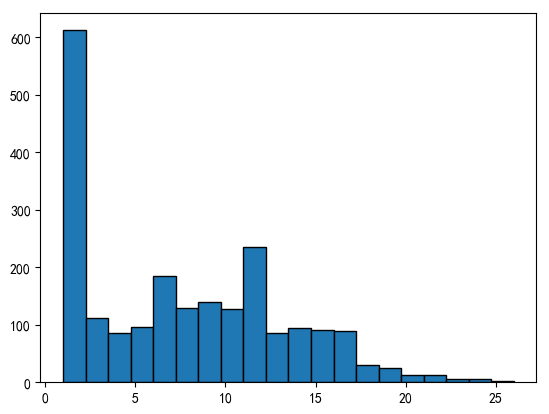

Wall time: 3min 33s


In [17]:
%%time
random = statistics_taxi(df)

## 1.4 可视化分析

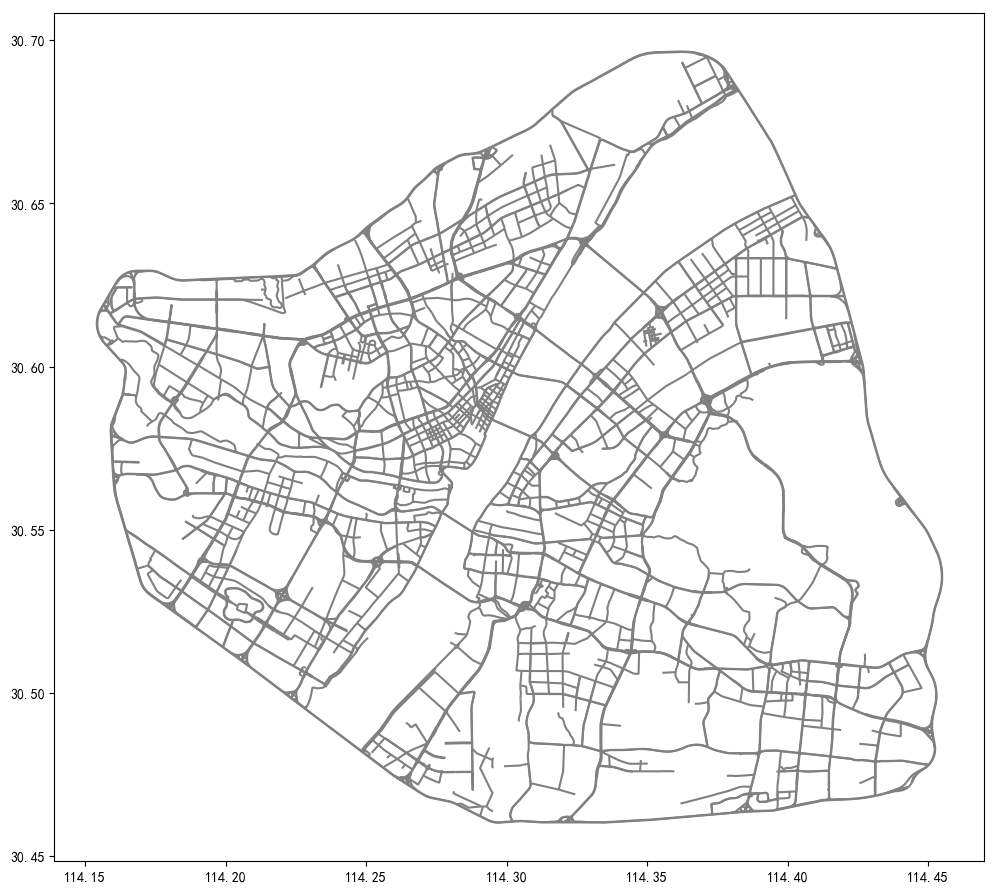

In [20]:
gdf = gp.read_file('实习一_开发环境配置与轨迹数据初探/data/roads/WHroad.shp')
ax = gdf.plot(color='grey',figsize=(12,12))
df = pd.read_csv('20181110_0_indexed.txt')

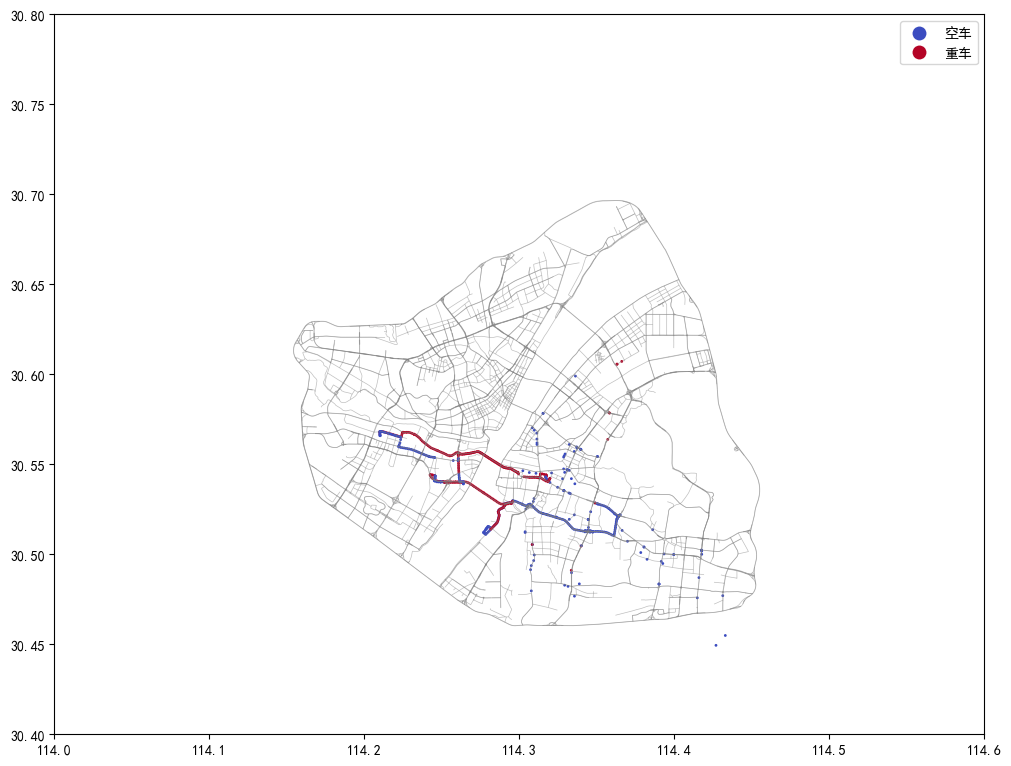

In [19]:
# 选取某一辆出租车作为示例进行处理 点
df1 = df[df['出租车ID']==9305] # 注意，如果未进行read_csv操作则为字符串，否则为纯数字
# 构造GeoDataFrame对象
gdf1 = gp.GeoDataFrame(df1,geometry=gp.points_from_xy(df1['经度'],df1['纬度']),crs=4326)
# 绘图，分别指定渲染字段、颜色表、显示图例、点大小、图片大小
ax = gdf1.plot(column='空车/重车',cmap='coolwarm',legend=True,markersize=1,figsize=(12,12))
# 指定范围
ax.set_ylim([30.4,30.8])
ax.set_xlim([114.0,114.6])
# 叠加武汉市路网
road = gp.read_file('实习一_开发环境配置与轨迹数据初探/data/roads/WHroad.shp')
road.plot(ax=ax,linewidth=0.5,alpha=0.5,color='grey')

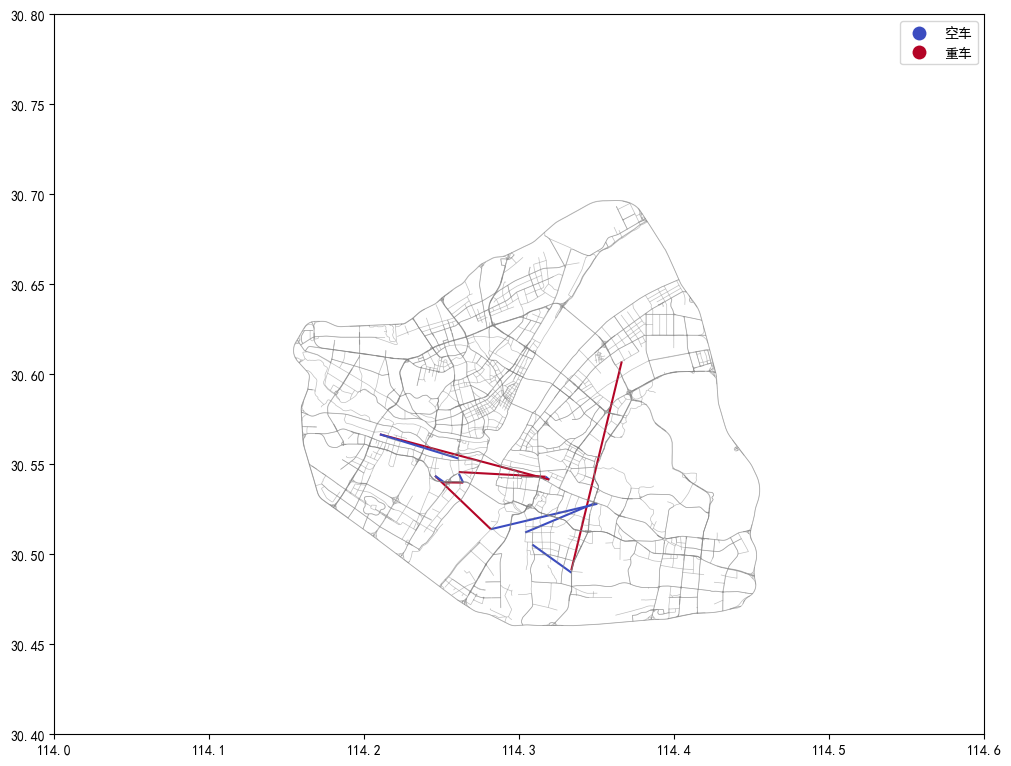

In [20]:
# 选取某一辆出租车作为示例进行处理 线
df1 = df[df['出租车ID']==9305]
# 构造GeoDataFrame对象
data = []
for tid in list(df1['轨迹ID'].unique()):
    df2 = df1[df1['轨迹ID']==tid]
    x1 = df2.iloc[0]['经度']
    y1 = df2.iloc[0]['纬度']
    x2 = df2.iloc[-1]['经度']
    y2 = df2.iloc[-1]['纬度']
    od_line = LineString([(x1,y1),(x2,y2)])
    data.append([od_line,df2.iloc[0]['空车/重车']])
lines = pd.DataFrame(data,columns=['geometry','空车/重车'])
gdf1 = gp.GeoDataFrame(lines,geometry='geometry',crs=4326)

# 绘图，分别指定渲染字段、颜色表、显示图例、点大小、图片大小
ax = gdf1.plot(column='空车/重车',cmap='coolwarm',legend=True,figsize=(12,12))
# 指定范围
ax.set_ylim([30.4,30.8])
ax.set_xlim([114.0,114.6])
# 叠加武汉市路网
road.plot(ax=ax,linewidth=0.5,alpha=0.5,color='grey')

Wall time: 1min 8s


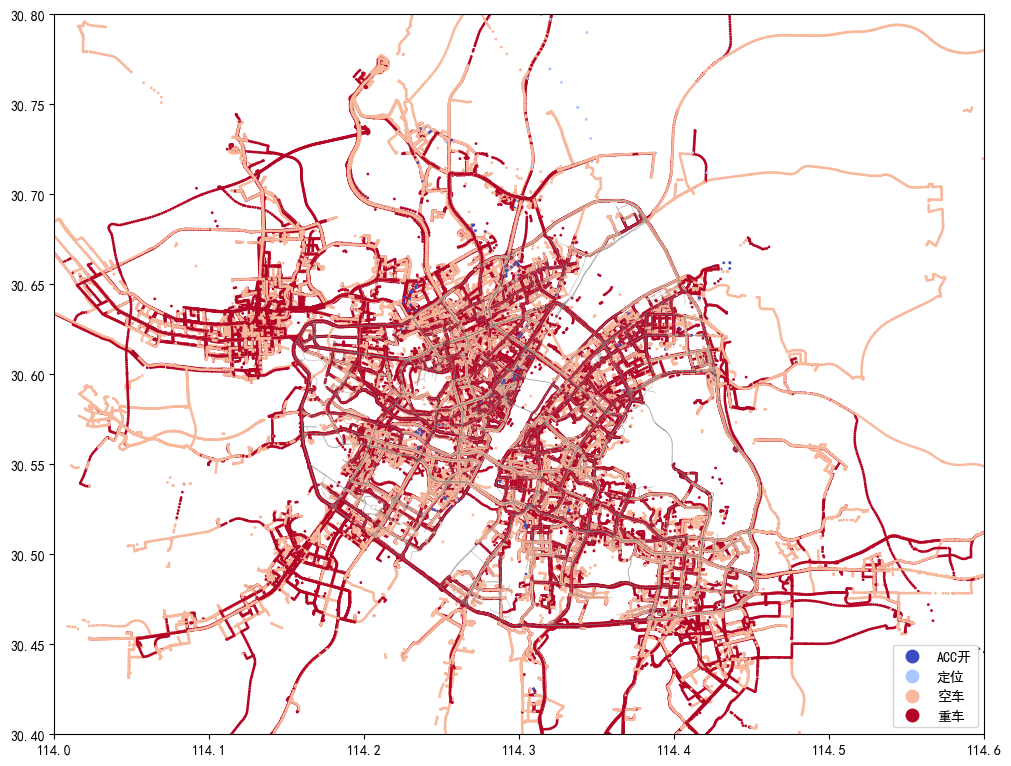

In [21]:
%%time
# 绘画所有数据 点
# 构造GeoDataFrame对象
gdf1 = gp.GeoDataFrame(df,geometry=gp.points_from_xy(df['经度'],df['纬度']),crs=4326)
# 绘图，分别指定渲染字段、颜色表、显示图例、点大小、图片大小
ax = gdf1.plot(column='空车/重车',cmap='coolwarm',legend=True,markersize=1,figsize=(12,12))
# 指定范围
ax.set_ylim([30.4,30.8])
ax.set_xlim([114.0,114.6])
# 叠加武汉市路网
road.plot(ax=ax,linewidth=0.5,alpha=0.5,color='grey')

# 2 轨迹数据预处理

In [22]:
df = pd.read_csv('20181110_0_indexed.txt')
transformer1 = Transformer.from_crs(4326, 32649)
transformer2 = Transformer.from_crs(32649, 4326)

## 2.1 轨迹滤波（+）

考虑速度和方向信息

In [2]:
# 简单线性插值 考虑速度和方向信息
def interpolation(trac):
    trac_inter_list=[]
    if len(trac)<10: # 对太少的轨迹进行剔除
        return pd.DataFrame()
    old_row = trac.iloc[0]
    old_time = datetime.datetime.strptime(old_row['定位时间'], "%Y-%m-%d %H:%M:%S")
    for index, row in trac.iterrows():
        time = datetime.datetime.strptime(row['定位时间'], "%Y-%m-%d %H:%M:%S")
        time_delta = (time - old_time).seconds
        # 20s内无数据，且上一个速度大于3km/h，则进行插值
        if time_delta>20 and float(old_row['速度'])>3:
            utm_x, utm_y = transformer1.transform(old_row['纬度'],old_row['经度']) # 转为utm坐标
            utm_x2, utm_y2 = transformer1.transform(row['纬度'],row['经度'])
            n = int(time_delta / 10) # 以10s为间隔插值
            dy = (utm_y2 - utm_y) / n
            dx = (utm_x2 - utm_x) / n
            dv = (float(row['速度']) - float(old_row['速度'])) / n
            dd = (float(row['方向']) - float(old_row['方向'])) / n
            for i in range(n-1):
                old_time = (old_time + datetime.timedelta(seconds=10))
                time_add = old_time.strftime("%Y-%m-%d %H:%M:%S")
                lat, lng = transformer2.transform(utm_x + dx * (i + 1), utm_y + dy * (i + 1))
                speed = float(old_row['速度']) + dv * (i + 1)
                direction = float(old_row['方向']) + dd * (i + 1)
                trac_inter_list.append([old_row['出租车ID'],time_add,lng,lat,direction,
                                       speed,old_row['空车/重车'],old_row['轨迹ID']])
        old_time = time
        old_row = row
        trac_inter_list.append(row.tolist())
    trac_inter = pd.DataFrame(trac_inter_list,columns=trac.columns)
    return trac_inter

In [24]:
# 选取某一辆出租车作为示例进行处理
df1 = df[df['出租车ID']==9305]
# 构造一个新的DataFrame用于存储插值后的轨迹点
df1_interpolated = pd.DataFrame()

# 轨迹分段
trac_ids = list(df1['轨迹ID'].unique())
for tid in trac_ids:
    trac = df1[df1['轨迹ID']==tid]
    trac_interpolated = interpolation(trac)
    
    df1_interpolated = df1_interpolated.append(trac_interpolated,ignore_index=True)
    
gdf1 = gp.GeoDataFrame(df1_interpolated,geometry=gp.points_from_xy(df1_interpolated['经度'],df1_interpolated['纬度']),crs=4326)
# 绘图
ax = gdf1.plot(column='空车/重车',cmap='coolwarm',legend=True,markersize=1,figsize=(12,12))
# 指定范围
ax.set_ylim([30.4,30.8])
ax.set_xlim([114.0,114.6])
# 叠加武汉市路网
road = gp.read_file('实习一_开发环境配置与轨迹数据初探/data/roads/WHroad.shp')
road.plot(ax=ax,linewidth=0.5,alpha=0.5,color='grey')

In [3]:
# 轨迹滤波 均值滤波
def mean_filter(trac,n):
    n = int(n / 2) * 2 + 1 # 窗口大小 奇数
    trac_filtered = trac.copy().reset_index(drop=True)
    for i in range(int(n / 2),len(trac) - int(n / 2)):
        # 对于中间的点，均值滤波
        sub_df = trac[i - int(n / 2):i + int(n / 2) + 1]
        lat = 0.0
        lng = 0.0
        for index, row in sub_df.iterrows():
            lat += float(row['纬度'])
            lng += float(row['经度'])
        lat /= n
        lng /= n
        # 将结果重新赋值
        trac_filtered.loc[i,'纬度'] = lat
        trac_filtered.loc[i,'经度'] = lng
    return trac_filtered

In [26]:
# 卡尔曼滤波 顾及速度与方向
def kalman_filter(trac):
    initial_state_mean = [trac.iloc[0]['经度'], trac.iloc[0]['纬度'],
                          trac.iloc[0]['速度'] * np.cos(np.radians(trac.iloc[0]['方向'])),
                          trac.iloc[0]['速度'] * np.sin(np.radians(trac.iloc[0]['方向']))]

    initial_state_covariance = np.eye(4)

    # 定义转换模型
    delta_t = 1
    transition_matrix = np.array([[1, 0, delta_t, 0],
                                  [0, 1, 0, delta_t],
                                  [0, 0, 1, 0],
                                  [0, 0, 0, 1]])

    transition_covariance = np.eye(4) * 0.1

    # 定义观测模型
    observation_matrix = np.array([[1, 0, 0, 0],
                                   [0, 1, 0, 0]])
    observation_covariance = np.eye(2) * 0.1

    # 创建卡尔曼滤波器对象
    kf = KalmanFilter(transition_matrices=transition_matrix,
                      observation_matrices=observation_matrix,
                      transition_covariance=transition_covariance,
                      observation_covariance=observation_covariance,
                      initial_state_mean=initial_state_mean,
                      initial_state_covariance=initial_state_covariance)

    # 准备观测矩阵
    n_samples = len(trac)
    observations = np.zeros((n_samples, 2))
    for idx, (i, row) in enumerate(trac.iterrows()):
        observations[idx] = [row['经度'], row['纬度']]

    # 应用卡尔曼滤波
    filtered_state_means, _ = kf.filter(observations)
    trac_filtered = trac.copy()
    trac_filtered['经度'] = filtered_state_means[:, 0]
    trac_filtered['纬度'] = filtered_state_means[:, 1]

    return trac_filtered

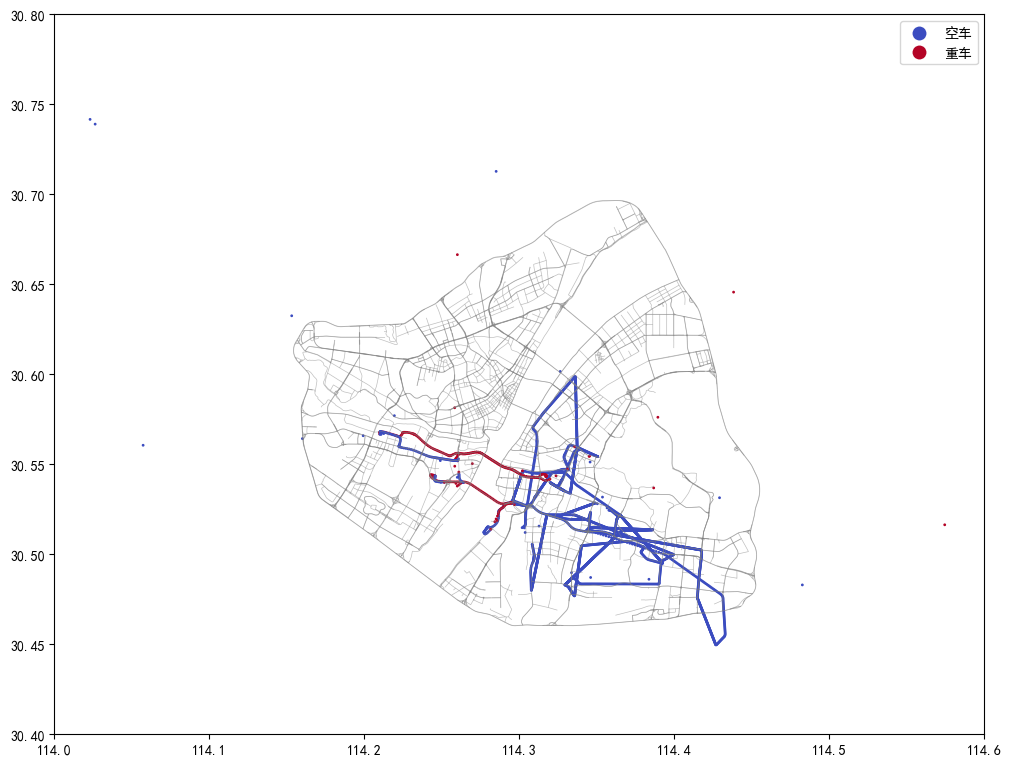

In [37]:
# 构造一个新的DataFrame用于存储滤波后的轨迹点
df1_interpolated_filtered = pd.DataFrame()

# 轨迹分段
trac_ids = list(df1_interpolated['轨迹ID'].unique())
for tid in trac_ids:
    trac_interpolated = df1_interpolated[df1_interpolated['轨迹ID']==tid]
    # 均值滤波
    # trac_interpolated_filtered = mean_filter(trac_interpolated,4)
    # 卡尔曼滤波
    trac_interpolated_filtered = kalman_filter(trac_interpolated)
    trac_interpolated_filtered2 = mean_filter(trac_interpolated_filtered,4)
    
    df1_interpolated_filtered = df1_interpolated_filtered.append(trac_interpolated_filtered2,ignore_index=True)

gdf2 = gp.GeoDataFrame(df1_interpolated_filtered,geometry=gp.points_from_xy(df1_interpolated_filtered['经度'],df1_interpolated_filtered['纬度']),crs=4326)
# 绘图
ax = gdf2.plot(column='空车/重车',cmap='coolwarm',legend=True,markersize=1,figsize=(12,12))
# 指定范围
ax.set_ylim([30.4,30.8])
ax.set_xlim([114.0,114.6])
# 叠加武汉市路网
road.plot(ax=ax,linewidth=0.5,alpha=0.5,color='grey')

## 2.2 轨迹压缩

In [28]:
# 上下车点提取
def get_od_and_trac(df):
    loads = []
    no_loads = []
    pick_up = []
    drop_off = []
    tids = list(df['轨迹ID'].unique())
    for tid in tids:
        sub_df = df[df['轨迹ID']==tid]
        status = sub_df.iloc[0]['空车/重车']
        row1 = sub_df.iloc[0]
        row2 = sub_df.iloc[-1]
        if status=='空车': # 空车轨迹
            no_loads.append(sub_df)
        else: # 重车OD为上下车点
            pick_up.append((row1['经度'],row1['纬度']))
            drop_off.append((row2['经度'],row2['纬度']))
            loads.append(sub_df)
    return loads,no_loads,pick_up,drop_off

In [29]:
%%time
loads, no_loads, pick_up, drop_off = get_od_and_trac(df)

Wall time: 19.6 s


In [5]:
# 坐标转换
def add_utm(loads):
    loads_utm = []
    for load in loads:
        X = []
        Y = []
        for i in range(len(load)):
            row = load.iloc[i]
            utm_x, utm_y = transformer1.transform(row['纬度'],row['经度'])
            X.append(utm_x)
            Y.append(utm_y)
        load_utm = load.copy()
        load_utm['X'] = X
        load_utm['Y'] = Y
        loads_utm.append(load_utm)
    return loads_utm

In [31]:
%%time
loads_utm = add_utm(loads)

Wall time: 55.4 s


In [6]:
# Douglas-Peucker算法
def Douglas_Peucker(loads,e):
    data = []
    for load in loads:
        idx = []
        X = load['X'].tolist()
        Y = load['Y'].tolist()
        curve = [ [X[i],Y[i]] for i in range(len(X)) ]
        result = rdp(curve,epsilon=e)
        result_wgs = []
        for point in result:
            lat,lng = transformer2.transform(point[0],point[1])
            result_wgs.append([lat,lng])
        data.append(pd.DataFrame(result_wgs,columns=['纬度','经度']))
    return data

In [33]:
%%time
df_dp = Douglas_Peucker(loads_utm,10)

Wall time: 1min 31s


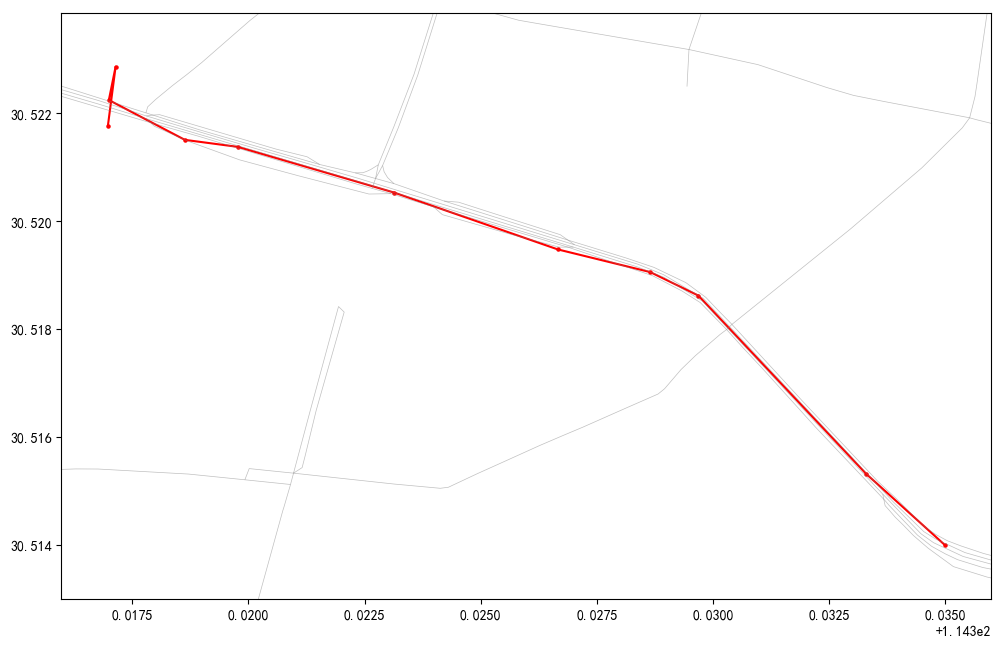

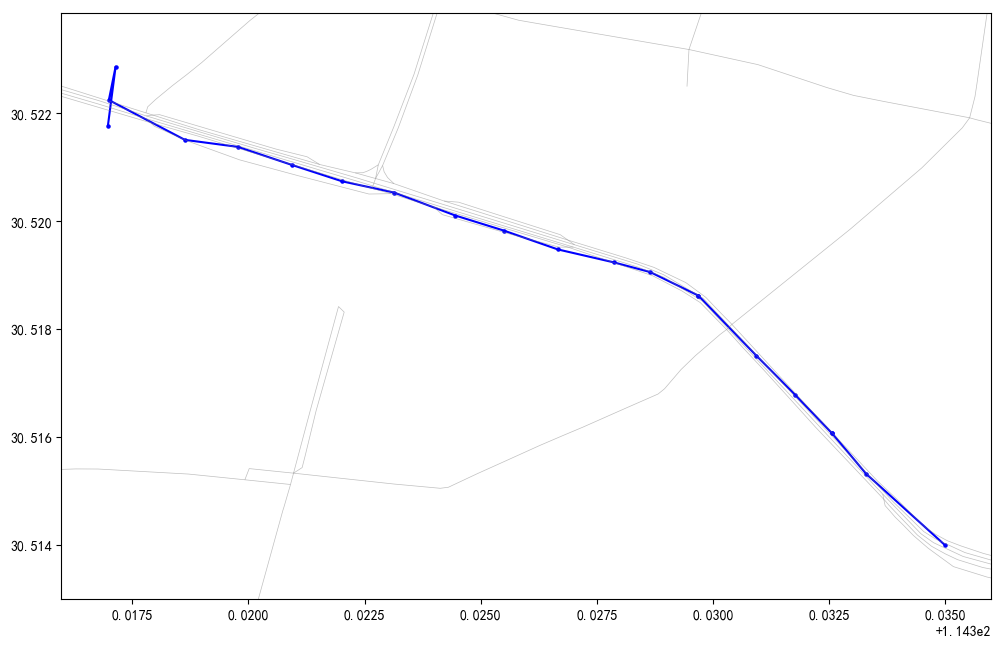

In [38]:
i = 1
gdf1 = gp.GeoDataFrame(df_dp[i],geometry=gp.points_from_xy(df_dp[i]['经度'],df_dp[i]['纬度']),crs=4326)
# 绘图
ax = gdf1.plot(color='red',markersize=5,figsize=(12,12))
# 指定范围
minx, miny, maxx, maxy = gdf1.total_bounds
ax.set_xlim(minx - 0.001, maxx + 0.001)
ax.set_ylim(miny - 0.001, maxy + 0.001)

xyList = [xy for xy in zip(gdf1['经度'],gdf1['纬度'])]
line = [LineString(xyList)]
gdf_line1 = gp.GeoDataFrame(pd.DataFrame(line,columns=['geometry']),geometry = 'geometry')
gdf_line1.plot(color='red',ax=ax)

# 叠加武汉市路网
road = gp.read_file('实习一_开发环境配置与轨迹数据初探/data/roads/WHroad.shp')
road.plot(ax=ax,linewidth=0.5,alpha=0.5,color='grey')

gdf2 = gp.GeoDataFrame(loads[i],geometry=gp.points_from_xy(loads[i]['经度'],loads[i]['纬度']),crs=4326)
# 绘图
ax = gdf2.plot(color='blue',markersize=5,figsize=(12,12))
# 指定范围
minx, miny, maxx, maxy = gdf2.total_bounds
ax.set_xlim(minx - 0.001, maxx + 0.001)
ax.set_ylim(miny - 0.001, maxy + 0.001)

xyList = [xy for xy in zip(gdf2['经度'],gdf2['纬度'])]
line = [LineString(xyList)]
gdf_line2 = gp.GeoDataFrame(pd.DataFrame(line,columns=['geometry']),geometry = 'geometry')
gdf_line2.plot(color='blue',ax=ax)

# 叠加武汉市路网
road.plot(ax=ax,linewidth=0.5,alpha=0.5,color='grey')

In [39]:
# 保存结果
data = []
tid = 0
for dp in df_dp:
    lats = dp['纬度'].tolist()
    lngs = dp['经度'].tolist()
    for i in range(len(lats)):
        data.append([lats[i],lngs[i],tid])
    tid += 1
data = pd.DataFrame(data,columns=['纬度','经度','轨迹ID'])
data.to_csv('20181110_0_dp.txt',index=False)

## 2.3 地图匹配（+）

In [40]:
# 投影相关
wgs84 = CRS.from_epsg(4326)
utm49N = CRS.from_epsg(32649)
myTrans = Transformer.from_crs(utm49N,wgs84)

# 武汉市路网
road = gp.read_file('实习一_开发环境配置与轨迹数据初探/data/roads/WHroad.shp')

In [4]:
# 指导书方法
def mapping(trac,radius,road):
    if len(trac)<=1:return pd.DataFrame()
    mapped = trac
    # 轨迹点连线
    xylist = [xy for xy in zip(trac['经度'],trac['纬度'])]
    line = LineString(xylist)
    gdf = gp.GeoDataFrame(geometry=[line],crs=4326)
    gdf = gdf.to_crs(32649) # WGS84转UTM zone 49N
    # 生成缓冲区
    gs_buffer = gdf.buffer(radius)
    gs_buffer = gs_buffer.to_crs(4326)
    gdf_buffer = gp.GeoDataFrame(geometry=gs_buffer)
    # 与路网求交
    road = road.to_crs(4326)
    subroad = gp.overlay(road,gdf_buffer,how='intersection').to_crs(32649)
    # 遍历点，求距离
    if len(subroad)==0:
        return mapper
    for index, row in trac.iterrows():
        pt = gp.GeoSeries([Point(row['经度'],row['纬度'])],crs=4326).to_crs(32649)
        # 使用nearest_points方法计算点到线上最近点，即匹配点
        npts = nearest_points(pt[0],subroad.geometry.unary_union)
        npt = npts[1]
        # 投影变换
        npt = myTrans.transform(npt.x,npt.y)
        mapped.loc[index,'经度'] = npt[1]
        mapped.loc[index,'纬度'] = npt[0]
    return mapped

In [42]:
# 使用底图匹配包Leuven.MapMatching
# 将GeoPandas路网数据转换为InMemMap对象
def road_to_inmemmap(road):
    inmem_map = InMemMap("my_map", use_latlon=True)
    for _, row in road.iterrows():
        line = row['geometry']
        for i in range(len(line.coords) - 1):
            inmem_map.add_node((line.coords[i][1], line.coords[i][0]), loc=(line.coords[i][1], line.coords[i][0]))
            inmem_map.add_node((line.coords[i + 1][1], line.coords[i + 1][0]), loc=(line.coords[i + 1][1], line.coords[i + 1][0]))
            inmem_map.add_edge((line.coords[i][1], line.coords[i][0]), (line.coords[i + 1][1], line.coords[i + 1][0]))

    return inmem_map

#使用DistanceMatcher函数
def mapping_Leuven(trac, radius, road):
    if len(trac) <= 1:
        return pd.DataFrame()
    # 将 road 转换为 InMemMap 对象
    inmem_map = road_to_inmemmap(road)
    # 创建 DistanceMatcher 对象
    matcher = DistanceMatcher(inmem_map, max_dist=radius, min_prob_norm=0.5)
    # 准备轨迹点
    path = [(row['纬度'], row['经度']) for _, row in trac.iterrows()]
    # 进行地图匹配
    matched_path, _ = matcher.match(path)
    # 更新经纬度
    trac_mapped = trac.copy()
    for i, (lat, lon) in enumerate(matched_path):
        trac_mapped.loc[i, '纬度'] = lat
        trac_mapped.loc[i, '经度'] = lon

    return trac_mapped

In [43]:
# 上下车点提取
def get_od_and_trac(df):
    loads = []
    no_loads = []
    pick_up = []
    drop_off = []
    tids = list(df['轨迹ID'].unique())
    for tid in tids:
        sub_df = df[df['轨迹ID']==tid]
        status = sub_df.iloc[0]['空车/重车']
        row1 = sub_df.iloc[0]
        row2 = sub_df.iloc[-1]
        if status=='空车': # 空车轨迹
            no_loads.append(sub_df)
        else: # 重车OD为上下车点
            pick_up.append((row1['经度'],row1['纬度']))
            drop_off.append((row2['经度'],row2['纬度']))
            loads.append(sub_df)
    return loads,no_loads,pick_up,drop_off

In [44]:
# 运行前需要运行get_od_and_trac()函数
# 选取某一辆出租车作为示例进行处理
df1 = df[df['出租车ID']==1002]
loads, no_loads, pick_up, drop_off = get_od_and_trac(df1)
# 距离缓冲区
dis = 50
new_df = pd.DataFrame()
# 仅载客
for trac in loads:
    trac = trac.reset_index(drop=True)
    # 指导书方法
    trac_mapped = mapping(trac,dis,road)
    # 底图匹配包Leuven.MapMatching
    # trac_mapped = mapping_Leuven(trac,dis,road)
    new_df = new_df.append(trac_mapped,ignore_index=True)

In [45]:
# loads DataFrame List 转 DataFrame
loads_data = pd.concat(loads)
loads_data.reset_index(drop=True, inplace=True)

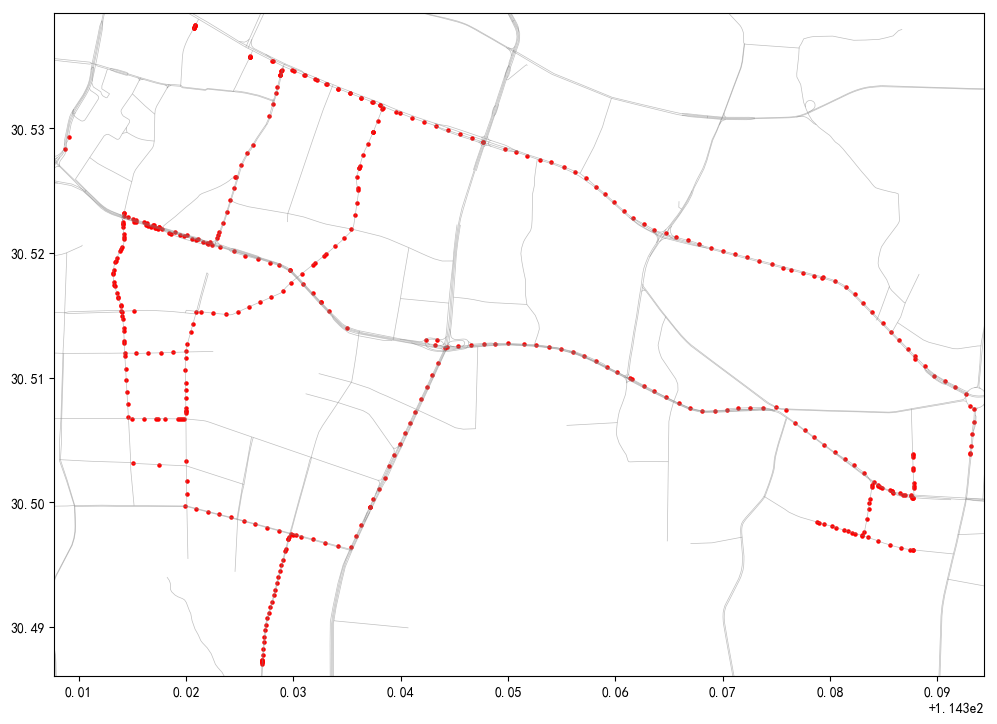

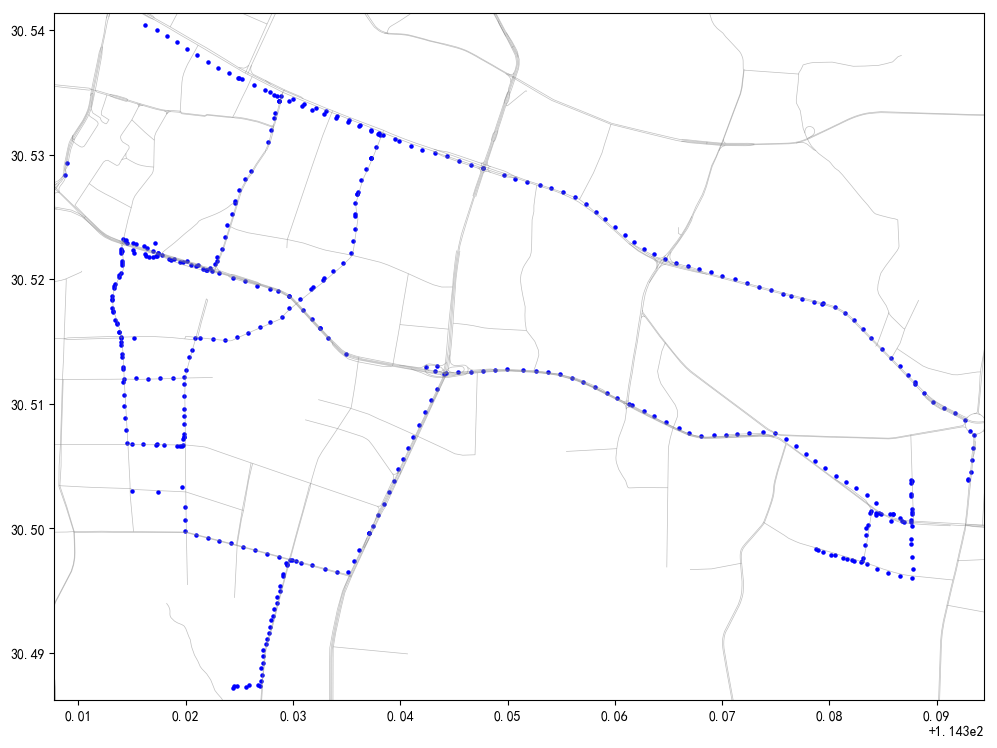

In [46]:
gdf1 = gp.GeoDataFrame(new_df,geometry=gp.points_from_xy(new_df['经度'],new_df['纬度']),crs=4326)
# 绘图
ax = gdf1.plot(color='red',markersize=5,figsize=(12,12))
# 指定范围
minx, miny, maxx, maxy = gdf1.total_bounds
ax.set_xlim(minx - 0.001, maxx + 0.001)
ax.set_ylim(miny - 0.001, maxy + 0.001)

# 绘制武汉市路网
road.plot(ax=ax,linewidth=0.5,alpha=0.5,color='grey')

gdf2 = gp.GeoDataFrame(loads_data,geometry=gp.points_from_xy(loads_data['经度'],loads_data['纬度']),crs=4326)
# 绘图
ax = gdf2.plot(color='blue',markersize=5,figsize=(12,12))
# 指定范围
minx, miny, maxx, maxy = gdf2.total_bounds
ax.set_xlim(minx - 0.001, maxx + 0.001)
ax.set_ylim(miny - 0.001, maxy + 0.001)

# 绘制武汉市路网
road.plot(ax=ax,linewidth=0.5,alpha=0.5,color='grey')

# 3 轨迹聚类与异常探测

In [5]:
# 预处理使用
transformer1 = Transformer.from_crs(4326, 32649)
transformer2 = Transformer.from_crs(32649, 4326)

# 投影相关
wgs84 = CRS.from_epsg(4326)
utm49N = CRS.from_epsg(32649)
myTrans = Transformer.from_crs(utm49N,wgs84)

## 3.1 轨迹距离度量

In [48]:
df = pd.read_csv('20181110_0_indexed.txt')

In [49]:
# 随机选择一条轨迹，长度为100-150之间中等长度轨迹
cnts = df['轨迹ID'].value_counts().tolist()
idxs = df['轨迹ID'].value_counts().index.tolist()
for i in range(len(cnts)):
    if cnts[i]>100 and cnts[i]<150:
        if rd.random()>0.5:
            break
tid = idxs[i]
trac = df[df['轨迹ID']==tid]

In [50]:
dtw_track1 = trac
# 随机丢弃
def randomly_drop(s,drop_size): # 对于序列s，随机丢弃其中drop_size个元素 实际去除点<=drop_size
    size = drop_size
    drops = []
    for i in range(size):
        drops.append(rd.randint(1,len(s)-1)) # 随机产生需要删除元素索引
    drops = list(set(drops)) # 去重
    dt2 = s.drop(s.index[drops])
    return dt2

dtw_track2 = randomly_drop(dtw_track1,30)
dtw_track3 = randomly_drop(dtw_track1,50)
print('轨迹1的长度：' + str(len(dtw_track1)))
print('轨迹2的长度：' + str(len(dtw_track2)))
print('轨迹3的长度：' + str(len(dtw_track3)))

轨迹1的长度：149
轨迹2的长度：123
轨迹3的长度：110


In [51]:
# DTW距离计算
def cal_dtw(track1,track2):
    dtw1_lat = track1['纬度']
    dtw1_lon = track1['经度']
    dtw2_lat = track2['纬度']
    dtw2_lon = track2['经度']
    
    # 直接使用fastdtw库
    dist_fast_lat, path1 = fastdtw(dtw1_lat, dtw2_lat, dist=euclidean) # 分别在经纬度上计算轨迹偏差
    dist_fast_lon, path2 = fastdtw(dtw1_lon, dtw2_lon, dist=euclidean)
    return (math.sqrt(dist_fast_lat ** 2 + dist_fast_lon ** 2))

In [52]:
print(cal_dtw(dtw_track1,dtw_track2))
print(cal_dtw(dtw_track1,dtw_track3))
print(cal_dtw(dtw_track2,dtw_track3))

0.02749987581792536
0.03857819489039143
0.04722797129883853


In [53]:
# 再次封装DP
# Douglas-Peucker算法
def Douglas_Peucker(trac,e):
    X = []
    Y = []
    trac_dp = []
    for i in range(len(trac)):
        row = trac.iloc[i]
        utm_X, utm_Y = transformer1.transform(row['纬度'],row['经度'])
        X.append(utm_X)
        Y.append(utm_Y)
        
    curve = [ [X[i],Y[i]] for i in range(len(X)) ]
    result = rdp(curve,epsilon=e)
    result_wgs = []
    for point in result:
        lat,lng = transformer2.transform(point[0],point[1])
        result_wgs.append([lat,lng])
    trac_dp = (pd.DataFrame(result_wgs,columns=['纬度','经度']))
    return trac_dp

In [54]:
# 压缩后DTW计算
dp_track1 = Douglas_Peucker(dtw_track1,10)
dp_track2 = Douglas_Peucker(dtw_track2,10)
dp_track3 = Douglas_Peucker(dtw_track3,10)

print(cal_dtw(dp_track1,dp_track2))
print(cal_dtw(dp_track1,dp_track3))
print(cal_dtw(dp_track2,dp_track3))

0.012067371047597078
0.022951594737619683
0.027345864861096282


## 3.2 轨迹层次聚类

In [9]:
# 轨迹点转线
def trac2line(trac):
    line = []
    for i in range(len(trac)):
        row = trac.iloc[i]
        line.append((row['纬度'],row['经度']))
    line = LineString(line)
    return line

# 生成差异大旋转轨迹
def trac_rotate(trac):
    line = []
    for i in range(len(trac)):
        row = trac.iloc[i]
        line.append((row['纬度'],row['经度']))
    angle = 0
    if rd.random()<0.25:
        angle = 0
    elif rd.random()<0.50:
        angle = 90
    elif rd.random()<0.55:
        angle = 180
    elif rd.random()<0.69:
        angle = 360
    rotated = affinity.rotate(LineString(line),angle,origin=(line[0][0],line[0][1]))
    return rotated

# 随机丢弃与旋转得新轨迹
def gen_random_tracs(trac,N):
    tracs = []
    # 轨迹本身
    line = trac2line(trac)
    tracs.append(line)
    for i in range(N):
        # 移除点与旋转
        # 移除点
        if rd.random()>0.5:
            trac1 = randomly_drop(trac,50)
        else:
            trac1 = trac
        # 旋转
        if rd.random()>0.5:
            line = trac_rotate(trac1)
        else:
            line = trac2line(trac1)
        tracs.append(line)
    return tracs

In [56]:
tracs_line = gen_random_tracs(trac,20)

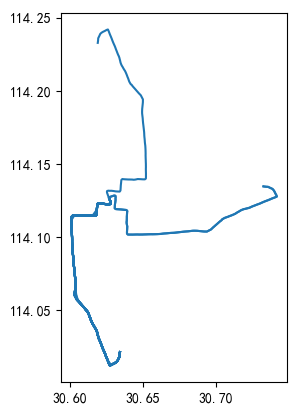

In [57]:
df = pd.DataFrame(tracs_line,columns=['geometry'])
gdf = gp.GeoDataFrame(df,geometry='geometry',crs=4326)
ax = gdf.plot(aspect=1,markersize=1)

In [58]:
# 数据格式转换
tdf = []
tid = 0
for t in tracs_line:
    for point in list(t.coords):
        tdf.append([point[0],point[1],tid])
    tid += 1
tdf = pd.DataFrame(tdf,columns=['纬度','经度','轨迹ID'])

In [10]:
# 获取轨迹坐标 json
def get_trac_coords(tdf,tIDs):
    tracs = [] # 存放轨迹点经纬度坐标
    new_id = 1
    for ids in tIDs:
        if ids % 1000==0:
            print(time.strftime("%Y-%m-%d %H:%M:%S",time.localtime()))
        trac_lons = tdf[tdf['轨迹ID']==ids]['经度'].values.tolist()
        trac_lats = tdf[tdf['轨迹ID']==ids]['纬度'].values.tolist()
        tracs.append({'tid': ids,'coords': [trac_lons, trac_lats]})
        new_id += 1
    return tracs

# DTW距离矩阵
def np_dtw_matrix(dataset):
    N = len(dataset)
    res = np.zeros((N,N),dtype='float32')
    for i in range(N):
        if i%50==0:
            print(time.strftime("%Y-%m-%d %H:%M:%S",time.localtime())) #较多时间用于动态求出两条一般轨迹的间距
        for j in range(i+1,N):
            dis_lon, _ = fastdtw(dataset[i]['coords'][0], dataset[j]['coords'][0], dist=euclidean)
            dis_lat, _ = fastdtw(dataset[i]['coords'][1], dataset[j]['coords'][1], dist=euclidean)
            res[i,j] = math.sqrt(dis_lat ** 2 + dis_lon ** 2)
            res[j,i] = res[i,j] #一半 复制
    return res

In [60]:
tids = range(tid)
trac_coords = get_trac_coords(tdf, tids)

print(len(trac_coords))

dtw_matr = np_dtw_matrix(trac_coords)

2023-05-13 15:35:26
21
2023-05-13 15:35:26


In [61]:
# 层次聚类
Z1 = sch.linkage(dtw_matr,method='average')

cluster = sch.fcluster(Z1,t=1,criterion='inconsistent')

d:\python37\lib\site-packages\ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


In [62]:
print(cluster)
print(len(set(cluster.tolist())))

[1 4 4 1 2 3 1 5 1 3 5 4 1 1 1 1 5 3 1 2 4]
5


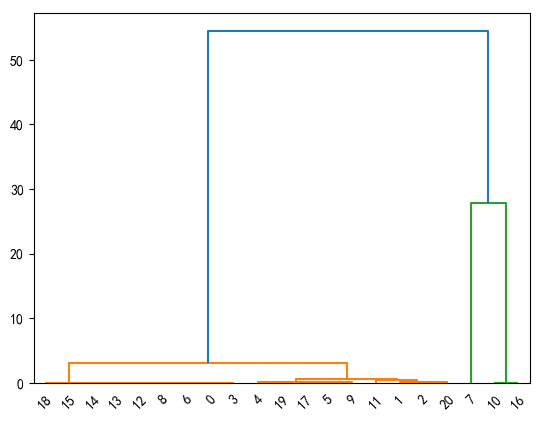

In [63]:
sch.dendrogram(Z1)
plt.show()

(30.600507, 30.742854999999988)

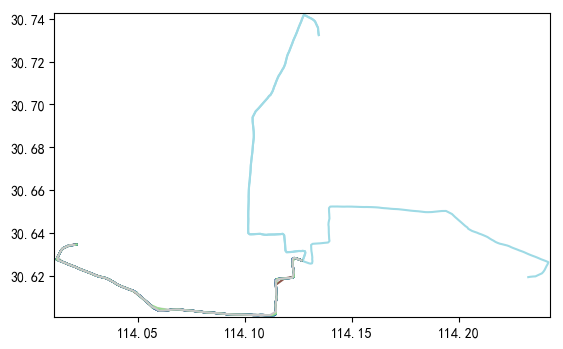

In [64]:
# 可视化解释类别
data = []
# 分类标签赋予对应轨迹
for i in range(0,len(trac_coords)):
    line = []
    coords = trac_coords[i]['coords']
    for j in range(len(coords[0])):
        line.append((coords[0][j],coords[1][j]))
    line = LineString(line)
    data.append([line,cluster.tolist()[i],i])
lines = pd.DataFrame(data,columns=['geometry','cluster','轨迹ID'])

# 可视化查看
gdf = gp.GeoDataFrame(lines, geometry='geometry')
ax = gdf.plot(column='cluster',cmap='tab20',markersize=1)
minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx - 0.001, maxx + 0.001)
ax.set_ylim(miny - 0.001, maxy + 0.001)

(30.600507, 30.635628)

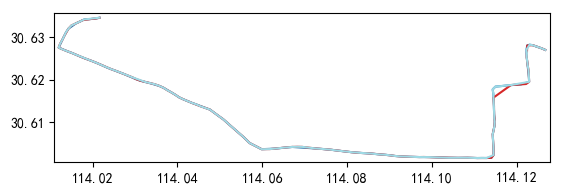

In [65]:
# 画一种同类
gdf = gp.GeoDataFrame(lines[lines['轨迹ID'].isin([5,9,17])], geometry='geometry')
ax = gdf.plot(column='轨迹ID',cmap='tab20',markersize=1)
minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx - 0.001, maxx + 0.001)
ax.set_ylim(miny - 0.001, maxy + 0.001)

## 3.3 轨迹异常探测(扩展部分)

In [79]:
%%time
# 数据切片数据量量过小，获取所有数据
# 需先运行数据初探部分
def extract_track_files(path):  # 抽取轨迹实习材料的原始轨迹文件夹中的txt文件
    # 使用原始字符串防止转义字符的干扰
    files = [filename for filename in glob.glob(path + r'\*.txt')]#遍历一个目录下面所有的存放轨迹的txt文件
    return files

dir = r'D:\学习\HZT\大三下\空间数据分析课程实习\实习一_开发环境配置与轨迹数据初探\data\raw'
files = extract_track_files(dir)
track_points = []
# 前五个文件
for file in files[:6]:
    track_point = get_track_points(file)
    track_points += track_point
    print(len(track_points))

999999
1999998
2999997
3999996
4999995
5999994
Wall time: 20.5 s


In [80]:
%%time
df = pd.DataFrame()
df = align_points(track_points)
df.sort_values(by=['出租车ID','定位时间'], inplace=True)
# 重新生成索引，确保索引正确
df = df.reset_index(drop=True)
df = modify_sorted(df)
df = set_tid2(df)
df.to_csv('20181110_indexed.txt',index=False)

Wall time: 6min 53s


In [6]:
# 此处开始运行！！！

# 获得子集数据
def get_sub_df(df,posrange,timerange):
    start_pos = get_address(f"{posrange[0][1]},{posrange[0][0]}")
    end_pos = get_address(f"{posrange[1][1]},{posrange[1][0]}")
    print('按空间范围',start_pos,'到',end_pos,'和时间范围',timerange[0],'到',timerange[1],'提取轨迹')
    sub_df = pd.DataFrame()
    sub_df=df[(df['经度']>=posrange[0][0])&(df['纬度']>=posrange[0][1])&(df['经度']<=posrange[1][0])&(df['纬度']<=posrange[1][1])]
    sub_df=sub_df[(sub_df['定位时间']>=timerange[0])&(sub_df['定位时间']<=timerange[1])]
    look_into_df(sub_df)
    sub_df = sub_df.reset_index(drop=True)
    return sub_df

# 描述数据
def look_into_df(df):
    print('******提取时空数据子集描述******')
    print('共',len(df),'行数据')
    print('其中有不同出租车共',len(df['出租车ID'].unique()),'辆')
    print('其中有轨迹共',len(df['轨迹ID'].unique()),'条')
    print('时间覆盖范围从',min(df['定位时间']),'到',max(df['定位时间']))
    start_pos = get_address(f"{min(df['纬度'])},{min(df['经度'])}")
    end_pos = get_address(f"{max(df['纬度'])},{max(df['经度'])}")
    print('空间覆盖范围从', start_pos, '(', min(df['经度']), ',', min(df['纬度']), ') 到', end_pos, '(', max(df['经度']), ',', max(df['纬度']), ')')

# 可视化
def visualize(df):
    gdf = gp.GeoDataFrame(df,geometry=gp.points_from_xy(df['经度'],df['纬度']),crs=4326)
    ax = gdf.plot(markersize=1,figsize=(12,12))
    # 指定范围
    ax.set_ylim([min(df['纬度'] - 0.001),max(df['纬度']) + 0.001])
    ax.set_xlim([min(df['经度'] - 0.001),max(df['经度'] + 0.001)])
    # 叠加武汉市路网
    road = gp.read_file('实习一_开发环境配置与轨迹数据初探/data/roads/WHroad.shp')
    road.plot(ax=ax,linewidth=0.5,alpha=0.5,color='grey')

In [7]:
# 逆地理编码
# encoding:utf-8
# 根据您选择的AK以为您生成调用代码
# 检测到您当前的AK设置了IP白名单校验
# 您的IP白名单中的IP非公网IP，请设置为公网IP，否则将请求失败
# 请在IP地址为0.0.0.0/0 外网IP的计算发起请求，否则将请求失败

# 服务地址
host = "https://api.map.baidu.com"
# 接口地址
uri = "/reverse_geocoding/v3"
# 此处填写你在控制台-应用管理-创建应用后获取的AK
ak = "ZZBDVHZvvQahXRo49g9QGaAl5oLd357w"

def get_address(coords):
    params = {
        "ak":       ak,
        "output":    "json",
        "coordtype":    "wgs84ll",
        "location":    coords,
    }
    response = requests.get(url = host + uri, params = params)
    if response:
        return response.json()['result']['formatted_address']
    
# get_address('30.52, 114.32')
# get_address('30.62, 114.43')

按空间范围 湖北省武汉市洪山区南湖路 到 湖北省武汉市武昌区 和时间范围 2018-11-10 00:00:00 到 2018-11-10 22:00:00 提取轨迹
******提取时空数据子集描述******
共 365117 行数据
其中有不同出租车共 1743 辆
其中有轨迹共 10688 条
时间覆盖范围从 2018-11-10 00:00:08 到 2018-11-10 21:29:55
空间覆盖范围从 湖北省武汉市洪山区南湖路 ( 114.305 , 30.51 ) 到 湖北省武汉市武昌区 ( 114.375 , 30.55 )


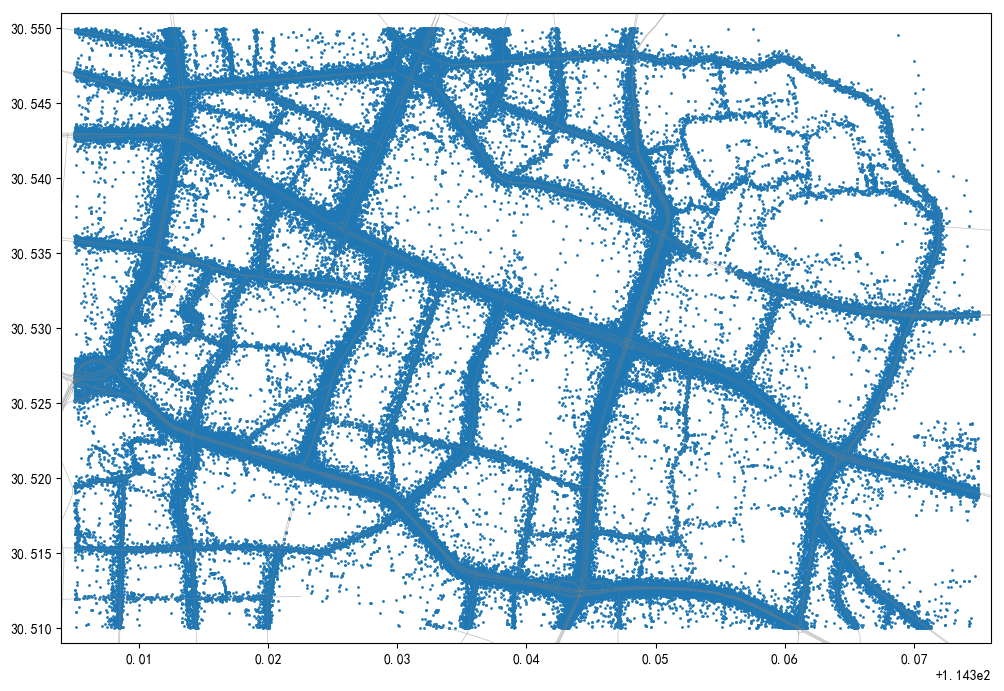

In [8]:
# 提取数据子集
df = pd.read_csv('20181110_indexed.txt')
# 武昌站坐标 114.3178887615967,30.528252836440785
# 武汉大学坐标 114.36449482543948,30.535867609628827
# 左下角坐标 涵盖武昌站 缩小经度以获取正常轨迹数据
start_coords = (114.305,30.51)
# 右上角坐标 涵盖武汉大学
end_coords = (114.375,30.55)
sub_df = get_sub_df(df,[start_coords,end_coords],['2018-11-10 00:00:00','2018-11-10 22:00:00'])
visualize(sub_df)

In [13]:
# 上下车点提取
def get_od_and_trac(df):
    loads = []
    no_loads = []
    pick_up = []
    drop_off = []
    tids = list(df['轨迹ID'].unique())
    for tid in tids:
        sub_df = df[df['轨迹ID']==tid]
        status = sub_df.iloc[0]['空车/重车']
        row1 = sub_df.iloc[0]
        row2 = sub_df.iloc[-1]
        if status=='空车': # 空车轨迹
            no_loads.append(sub_df)
        else: # 重车OD为上下车点
            pick_up.append((row1['经度'],row1['纬度']))
            drop_off.append((row2['经度'],row2['纬度']))
            loads.append(sub_df)
    return loads,no_loads,pick_up,drop_off
loads, no_loads, pick_up, drop_off = get_od_and_trac(sub_df)

20


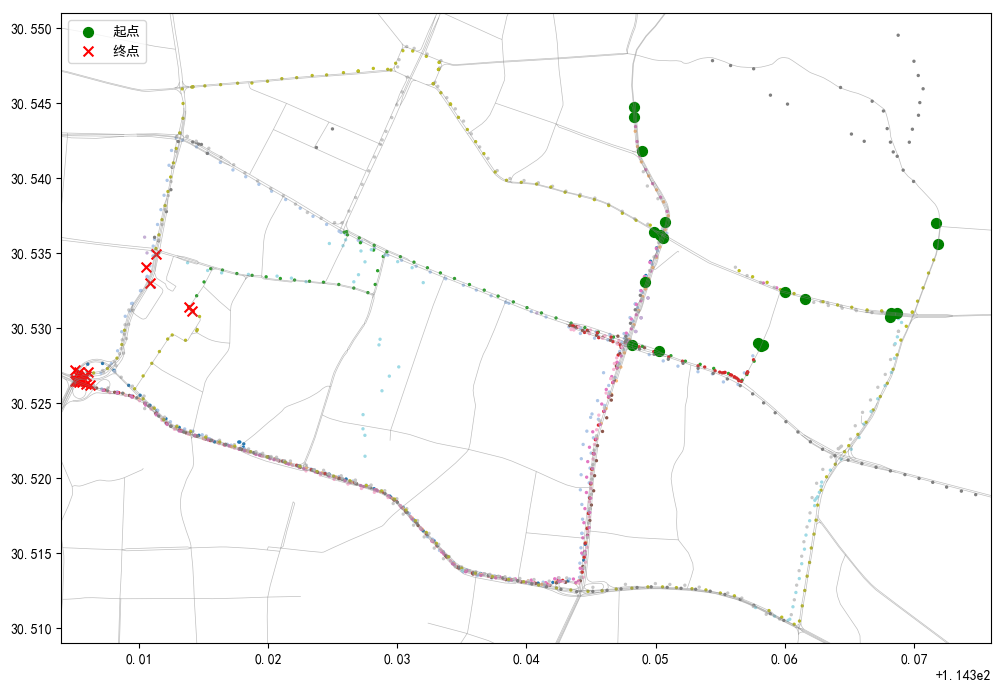

In [16]:
# 提取特定轨迹
new_df = pd.DataFrame()
tid = 0
# 仅考虑载客轨迹
for trac in loads:
    trac = trac.reset_index(drop=True)
    # 选取从武汉大学出发，到达武昌站的轨迹
    if abs(trac.loc[0,'经度']-114.36)<0.012 and abs(trac.loc[0,'纬度']-30.54)<0.012 and abs(trac.loc[len(trac)-1,'经度']-114.31)<0.005 and abs(trac.loc[len(trac)-1,'纬度']-30.53)<0.005:
        trac['TID'] = tid
        tid += 1
        new_df = new_df.append(trac)
        
new_df = new_df.reset_index(drop=True)
print(len(new_df['TID'].unique()))

fig, ax = plt.subplots(figsize=(12, 12))
gdf = gp.GeoDataFrame(new_df,geometry=gp.points_from_xy(new_df['经度'],new_df['纬度']),crs=4326)
gdf_start = gdf.groupby('轨迹ID').first()
gdf_end = gdf.groupby('轨迹ID').last()
gdf.plot(ax=ax,column='轨迹ID',cmap='tab20',markersize=2)
# 为起点和终点分别绘图
gdf_start.plot(ax=ax, color='green', marker='o', markersize=50, label='起点') # 绿色圆圈表示起点
gdf_end.plot(ax=ax, color='red', marker='x', markersize=50, label='终点') # 红色叉号表示终点
ax.legend()
# 指定范围
ax.set_ylim([min(sub_df['纬度']) - 0.001,max(sub_df['纬度']) + 0.001])
ax.set_xlim([min(sub_df['经度']) - 0.001,max(sub_df['经度']) + 0.001])
# 叠加武汉市路网
road = gp.read_file('实习一_开发环境配置与轨迹数据初探/data/roads/WHroad.shp')
road.plot(ax=ax,linewidth=0.5,alpha=0.5,color='grey')

In [17]:
# 修改列序，以免geometry处填充TID
order = ['出租车ID', '定位时间', '经度', '纬度', '方向', '速度', '空车/重车', '轨迹ID', 'TID', 'geometry']
new_df = new_df[order]
print(new_df)
new_df.to_csv('20181110_indexed_new.txt',index=False)

      出租车ID                 定位时间          经度         纬度   方向  速度 空车/重车   轨迹ID  \
0      1054  2018-11-10 09:49:58  114.349848  30.536392  112   7    重车   2206   
1      1054  2018-11-10 09:50:28  114.349947  30.536185  136  14    重车   2206   
2      1054  2018-11-10 09:50:47  114.350072  30.535343  194  30    重车   2206   
3      1054  2018-11-10 09:50:57  114.349608  30.534452  198  37    重车   2206   
4      1054  2018-11-10 09:51:07  114.349242  30.533503  198  45    重车   2206   
...     ...                  ...         ...        ...  ...  ..   ...    ...   
1363    941  2018-11-10 09:23:01  114.318473  30.533575  274  47    重车  64606   
1364    941  2018-11-10 09:24:31  114.316400  30.533678  272  27    重车  64606   
1365    941  2018-11-10 09:24:43  114.315318  30.533837  284  37    重车  64606   
1366    941  2018-11-10 09:25:13  114.313762  30.534353  286  19    重车  64606   
1367    941  2018-11-10 09:25:43  114.311302  30.534910  290  20    重车  64606   

      TID                  

In [18]:
%%time
# 轨迹插值与滤波
# 简单线性插值 考虑速度和方向信息
def interpolation(trac):
    trac_inter_list=[]
    if len(trac)<10: # 对太少的轨迹进行剔除
        return pd.DataFrame()
    old_row = trac.iloc[0]
    old_time = datetime.datetime.strptime(old_row['定位时间'], "%Y-%m-%d %H:%M:%S")
    for index, row in trac.iterrows():
        time = datetime.datetime.strptime(row['定位时间'], "%Y-%m-%d %H:%M:%S")
        time_delta = (time - old_time).seconds
        # 20s内无数据，且上一个速度大于3km/h，则进行插值
        if time_delta>20 and float(old_row['速度'])>3:
            utm_x, utm_y = transformer1.transform(old_row['纬度'],old_row['经度']) # 转为utm坐标
            utm_x2, utm_y2 = transformer1.transform(row['纬度'],row['经度'])
            n = int(time_delta / 10) # 以10s为间隔插值
            dy = (utm_y2 - utm_y) / n
            dx = (utm_x2 - utm_x) / n
            dv = (float(row['速度']) - float(old_row['速度'])) / n
            dd = (float(row['方向']) - float(old_row['方向'])) / n
            for i in range(n-1):
                old_time = (old_time + datetime.timedelta(seconds=10))
                time_add = old_time.strftime("%Y-%m-%d %H:%M:%S")
                lat, lng = transformer2.transform(utm_x + dx * (i + 1), utm_y + dy * (i + 1))
                speed = float(old_row['速度']) + dv * (i + 1)
                direction = float(old_row['方向']) + dd * (i + 1)
                trac_inter_list.append([old_row['出租车ID'],time_add,lng,lat,direction,
                                       speed,old_row['空车/重车'],old_row['轨迹ID'],old_row['TID']])
        old_time = time
        old_row = row
        trac_inter_list.append(row.tolist())
    trac_inter = pd.DataFrame(trac_inter_list,columns=trac.columns)
    return trac_inter

# 构造一个新的DataFrame用于存储插值后的轨迹点
new_df_interpolated = pd.DataFrame()

# 轨迹分段
trac_ids = list(new_df['轨迹ID'].unique())
for tid in trac_ids:
    trac = new_df[new_df['轨迹ID']==tid]
    trac_interpolated = interpolation(trac)
    
    new_df_interpolated = new_df_interpolated.append(trac_interpolated,ignore_index=True)

print(len(new_df_interpolated['TID'].unique()))
# 构造一个新的DataFrame用于存储滤波后的轨迹点
new_df_filtered = pd.DataFrame()

# 轨迹分段
trac_ids = list(new_df_interpolated['轨迹ID'].unique())
for tid in trac_ids:
    trac = new_df_interpolated[new_df_interpolated['轨迹ID']==tid]
    # 均值滤波
    trac_filtered = mean_filter(trac,4)
    # 卡尔曼滤波
    # trac_filtered = kalman_filter(trac)
    
    new_df_filtered = new_df_filtered.append(trac_filtered,ignore_index=True)

20
Wall time: 1.37 s


In [88]:
# %%time
# # 轨迹压缩
# new_df_filtered_list = []
# tids = list(new_df_filtered['轨迹ID'].unique())
# for tid in tids:
#     sub_df = new_df_filtered[new_df_filtered['轨迹ID']==tid]
#     new_df_filtered_list.append(sub_df)

# new_df_filtered_list_utm = add_utm(new_df_filtered_list)
# new_df_filtered_dp = Douglas_Peucker(new_df_filtered_list_utm,10)

In [19]:
%%time
# 地图匹配
new_df_filtered_list = []
tids = list(new_df_filtered['轨迹ID'].unique())
for tid in tids:
    sub_df = new_df_filtered[new_df_filtered['轨迹ID']==tid]
    new_df_filtered_list.append(sub_df)

# 距离缓冲区
dis = 100
new_df_matched = pd.DataFrame()
# 仅载客
for trac in new_df_filtered_list:
    trac = trac.reset_index(drop=True)
    # 指导书方法
    trac_mapped = mapping(trac,dis,road)
    # 底图匹配包Leuven.MapMatching
    # trac_mapped = mapping_Leuven(trac,dis,road)
    new_df_matched = new_df_matched.append(trac_mapped,ignore_index=True)

Wall time: 33.2 s


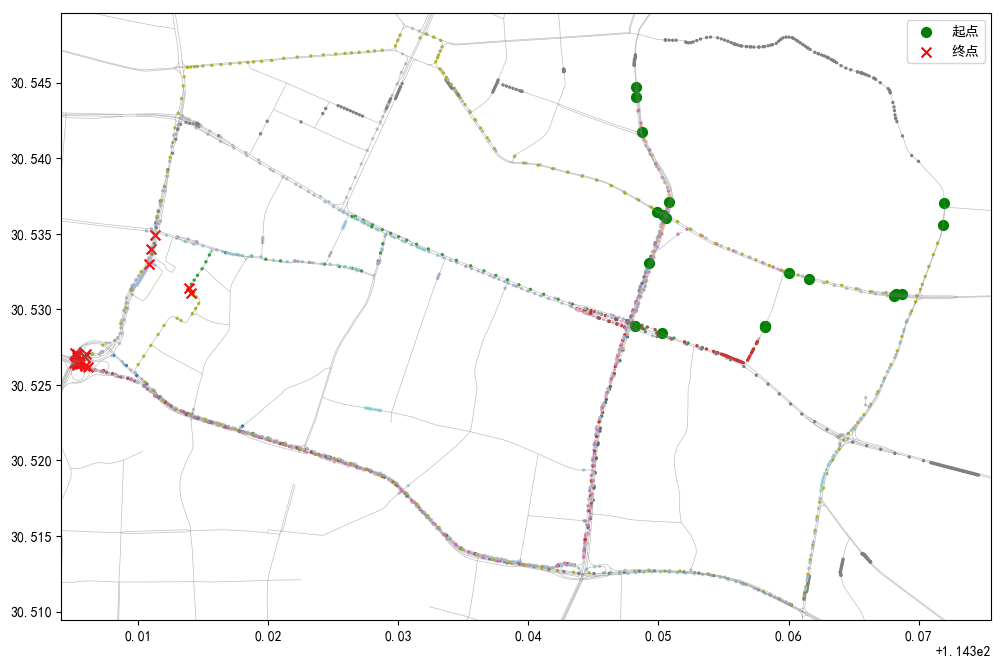

In [21]:
fig, ax = plt.subplots(figsize=(12, 12))
gdf = gp.GeoDataFrame(new_df_matched,geometry=gp.points_from_xy(new_df_matched['经度'],new_df_matched['纬度']),crs=4326)
gdf_start = gdf.groupby('轨迹ID').first()
gdf_end = gdf.groupby('轨迹ID').last()
gdf.plot(ax=ax,column='轨迹ID',cmap='tab20',markersize=2)
# 为起点和终点分别绘图
gdf_start.plot(ax=ax, color='green', marker='o', markersize=50, label='起点') # 绿色圆圈表示起点
gdf_end.plot(ax=ax, color='red', marker='x', markersize=50, label='终点') # 红色叉号表示终点
ax.legend()
# 指定范围
minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx - 0.001, maxx + 0.001)
ax.set_ylim(miny - 0.001, maxy + 0.001)

# 绘制武汉市路网
road.plot(ax=ax,linewidth=0.5,alpha=0.5,color='grey')

In [22]:
print(new_df_matched)
new_df_matched.to_csv('20181110_indexed_matched.txt',index=False)

      出租车ID                 定位时间          经度         纬度          方向  \
0      1054  2018-11-10 09:49:58  114.349905  30.536451  112.000000   
1      1054  2018-11-10 09:50:08  114.349963  30.536410  120.000000   
2      1054  2018-11-10 09:50:18  114.350153  30.536256  128.000000   
3      1054  2018-11-10 09:50:28  114.350220  30.535612  136.000000   
4      1054  2018-11-10 09:50:47  114.350081  30.535130  194.000000   
...     ...                  ...         ...        ...         ...   
2009    941  2018-11-10 09:25:03  114.314265  30.534313  285.333333   
2010    941  2018-11-10 09:25:13  114.313623  30.534481  286.000000   
2011    941  2018-11-10 09:25:23  114.312959  30.534702  287.333333   
2012    941  2018-11-10 09:25:33  114.312180  30.534900  288.666667   
2013    941  2018-11-10 09:25:43  114.311302  30.534908  290.000000   

             速度 空车/重车   轨迹ID  TID                    geometry  
0      7.000000    重车   2206    0  POINT (114.34991 30.53645)  
1      9.333333    

In [23]:
# 点转线
new_df_2line_list = []
new_df = pd.read_csv('20181110_indexed_new.txt')
new_df_matched = pd.read_csv('20181110_indexed_matched.txt')

# 轨迹分段
trac_ids = list(new_df_matched['轨迹ID'].unique())
for tid in trac_ids:
    trac = new_df_matched[new_df_matched['轨迹ID']==tid]
    # 点转线
    trac_2line = trac2line(trac)
    
    new_df_2line_list.append(trac_2line)

In [24]:
# 数据格式转换
new_df_2line = []
tid = 0
for t in new_df_2line_list:
    for point in list(t.coords):
        new_df_2line.append([point[0],point[1],tid])
    tid += 1
new_df_2line = pd.DataFrame(new_df_2line,columns=['纬度','经度','TID'])

In [25]:
# 获取轨迹坐标 json 更改了原部分代码
def get_trac_coords(tdf,tIDs):
    tracs = [] # 存放轨迹点经纬度坐标
    new_id = 1
    for ids in tIDs:
        if ids % 1000==0:
            print(time.strftime("%Y-%m-%d %H:%M:%S",time.localtime()))
        trac_lons = tdf[tdf['TID']==ids]['经度'].values.tolist()
        trac_lats = tdf[tdf['TID']==ids]['纬度'].values.tolist()
        tracs.append({'tid': ids,'coords': [trac_lons, trac_lats]})
        new_id += 1
    return tracs
# 计算DTW矩阵
tids = range(tid)
trac_coords = get_trac_coords(new_df_2line, tids)

print(len(trac_coords))

dtw_matr = np_dtw_matrix(trac_coords)

2023-05-14 00:53:15
20
2023-05-14 00:53:15


[1 1 3 7 2 7 3 7 4 5 2 4 8 9 2 7 6 6 7 6]
9


d:\python37\lib\site-packages\ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


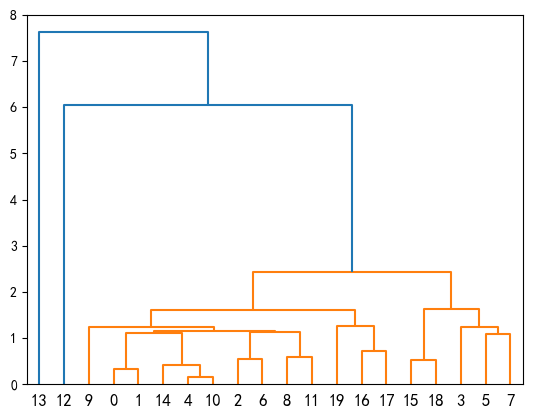

In [26]:
# 层次聚类 single链接会倾向于创建长链状的簇
Z1 = sch.linkage(dtw_matr,method='single')

cluster = sch.fcluster(Z1,t=1,criterion='inconsistent')
print(cluster)
print(len(set(cluster.tolist())))
sch.dendrogram(Z1)
plt.show()

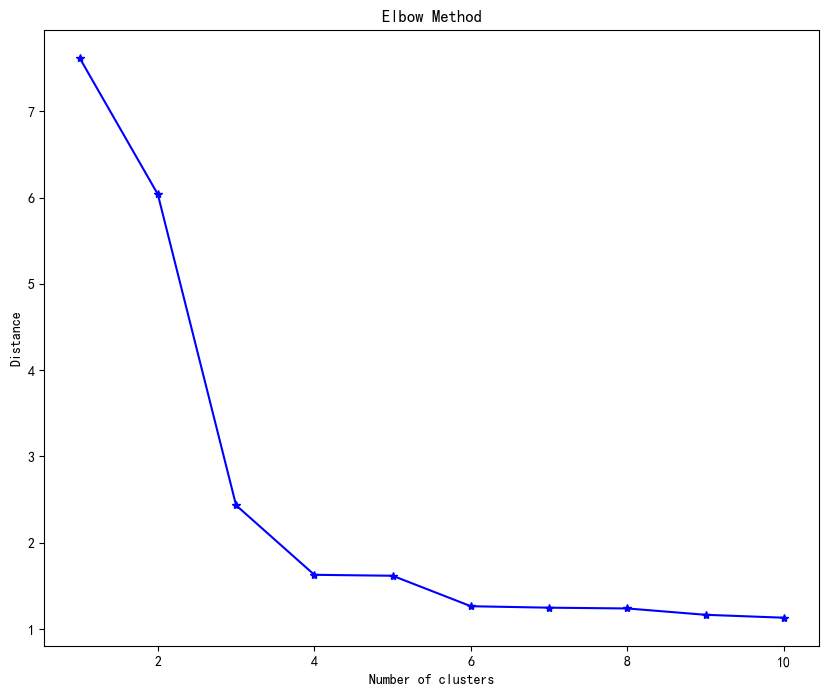

肘部法则（Elbow Method）判断最佳聚类数
最佳聚类数目为：3


In [27]:
# 使用肘部法则（Elbow Method）判断最佳聚类数
# 随着聚类数目的增加，SSE会减小；但是在某一点，SSE的减少幅度会骤然减小，这一点就像人的肘部，因此被称为“肘部”。肘部对应的聚类数目通常被认为是最佳的聚类数目

# 使用肘部法则
last = Z1[-10:, 2]
last_rev = last[::-1]
idxs = range(1, len(last) + 1)
plt.figure(figsize=(10, 8))
plt.plot(idxs, last_rev, 'b*-')
plt.xlabel('Number of clusters')
plt.ylabel('Distance')
plt.title('Elbow Method')
plt.show()

# 将idxs转换为NumPy数组
idxs = np.array(idxs)
# 计算斜率
m = (last_rev[1:] - last_rev[:-1]) / (idxs[1:] - idxs[:-1])
# 找到斜率绝对值最大的点，也就是肘部点
elbow = np.argmax(abs(m)) + 2  # 加2是因为Python索引从0开始，而斜率从2开始计算
print('肘部法则（Elbow Method）判断最佳聚类数')
print(f'最佳聚类数目为：{elbow}')

In [28]:
# 层次聚类 肘部法则定最佳聚类数
cluster1 = sch.fcluster(Z1,t=elbow,criterion='maxclust')
print(cluster1)
print(len(set(cluster1.tolist())))

[1 1 1 1 1 1 1 1 1 1 1 1 2 3 1 1 1 1 1 1]
3


In [29]:
# 使用轮廓系数（Silhouette Coefficient）判断最佳聚类数
# 轮廓系数是一种评估聚类效果的指标，它结合了聚类的凝聚度（Cohesion）和分离度（Separation），取值范围为[-1,1]。轮廓系数越接近1，表示样本点越应该被聚类到当前的簇；轮廓系数越接近-1，表示样本点越不应该被聚类到当前的簇。

# 选择一个t值的范围
t_values = range(2, len(trac_coords))  # 尝试从2到轨迹条数的聚类数量

best_t = None
best_score = -1

for t in t_values:
    # 进行层次聚类
    cluster = sch.fcluster(Z1, t=t, criterion='maxclust')
    # 计算轮廓系数
    score = silhouette_score(dtw_matr, cluster, metric='precomputed')
    # 如果这个轮廓系数更好，就更新最佳的t值和最佳的轮廓系数
    if score > best_score:
        best_t = t
        best_score = score

print('轮廓系数（Silhouette Coefficient）判断最佳聚类数')
print('最佳的聚类值为：', best_t)
print('对应的轮廓系数为：', best_score)

轮廓系数（Silhouette Coefficient）判断最佳聚类数
最佳的聚类值为： 6
对应的轮廓系数为： 0.58746374


In [30]:
# 层次聚类 轮廓系数定最佳聚类数
cluster2 = sch.fcluster(Z1,t=best_t,criterion='maxclust')
print(cluster2)
print(len(set(cluster2.tolist())))

[1 1 1 4 1 4 1 4 1 1 1 1 5 6 1 3 2 2 3 2]
6


(30.509435886597586, 30.54959315487536)

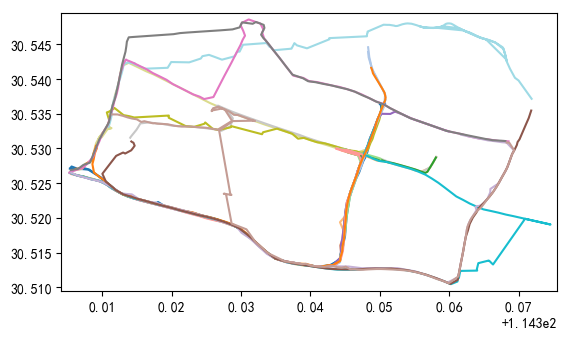

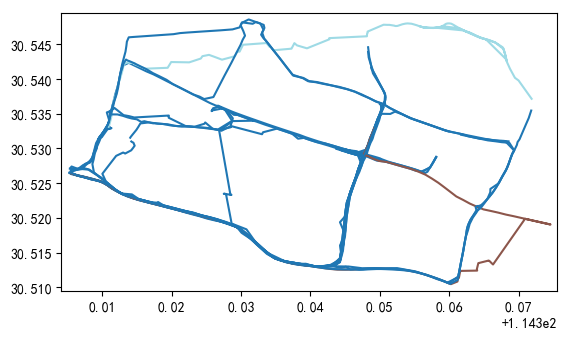

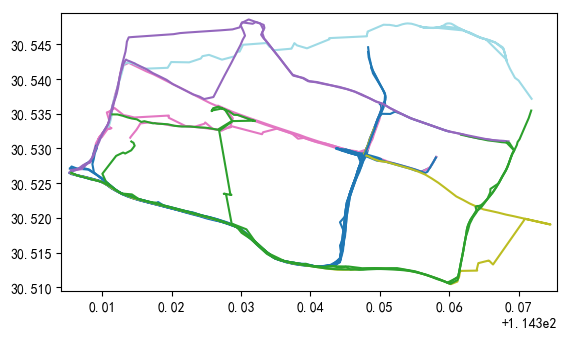

In [31]:
# 可视化解释类别
data = []
# 分类标签赋予对应轨迹
for i in range(0,len(trac_coords)):
    line = []
    coords = trac_coords[i]['coords']
    for j in range(len(coords[0])):
        line.append((coords[0][j],coords[1][j]))
    line = LineString(line)
    data.append([line,cluster.tolist()[i],cluster1.tolist()[i],cluster2.tolist()[i],i])
new_df_lines = pd.DataFrame(data,columns=['geometry','cluster','cluster1','cluster2','TID'])

# 可视化查看
gdf = gp.GeoDataFrame(new_df_lines, geometry='geometry')
ax = gdf.plot(column='cluster',cmap='tab20',markersize=1)
minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx - 0.001, maxx + 0.001)
ax.set_ylim(miny - 0.001, maxy + 0.001)

gdf1 = gp.GeoDataFrame(new_df_lines, geometry='geometry')
ax = gdf1.plot(column='cluster1',cmap='tab20',markersize=1)
minx, miny, maxx, maxy = gdf1.total_bounds
ax.set_xlim(minx - 0.001, maxx + 0.001)
ax.set_ylim(miny - 0.001, maxy + 0.001)

gdf2 = gp.GeoDataFrame(new_df_lines, geometry='geometry')
ax = gdf2.plot(column='cluster2',cmap='tab20',markersize=1)
minx, miny, maxx, maxy = gdf2.total_bounds
ax.set_xlim(minx - 0.001, maxx + 0.001)
ax.set_ylim(miny - 0.001, maxy + 0.001)

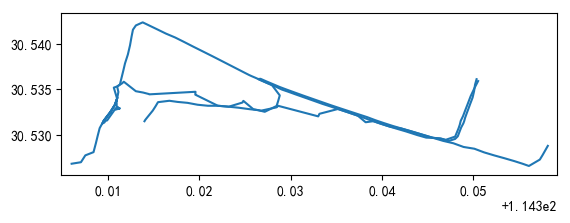

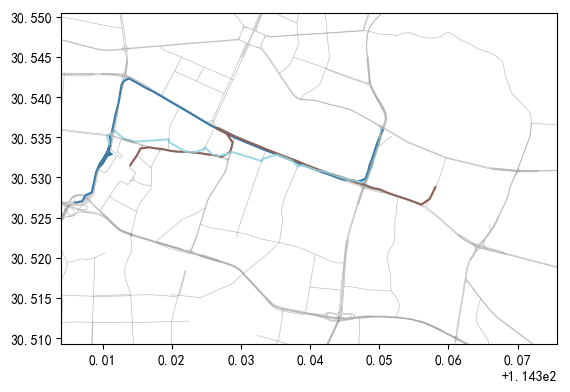

In [32]:
# 画一种同类 示例
gdf = gp.GeoDataFrame(new_df_lines[new_df_lines['TID'].isin([3,5,7])], geometry='geometry')
ax = gdf.plot(column='cluster2',cmap='tab20',markersize=1)
minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx - 0.001, maxx + 0.001)
ax.set_ylim(miny - 0.001, maxy + 0.001)

gdf1 = gp.GeoDataFrame(new_df_lines[new_df_lines['TID'].isin([3,5,7,23])], geometry='geometry')
ax = gdf1.plot(column='TID',cmap='tab20',markersize=1)
ax.set_xlim(min(new_df['经度']) - 0.001,max(new_df['经度']) + 0.001)
ax.set_ylim(min(new_df['纬度']) - 0.001,max(new_df['纬度']) + 0.001)
# 叠加武汉市路网
road.plot(ax=ax,linewidth=0.5,alpha=0.5,color='grey')

In [33]:
# 选择最佳聚类数对应的聚类 此修改即可
best_cluster = cluster2
best_cluster_str = 'cluster2'

unique, counts = np.unique(best_cluster, return_counts=True)
statics = dict(zip(unique, counts))

# 获取字典中特定值的键
def getDictKey(myDict, value):
    keyList = []
    for k, v in myDict.items():
        if v == value:
            keyList.append(k)
    return keyList
keyList = getDictKey(statics,1)
tidList = new_df_lines[new_df_lines[best_cluster_str].isin(keyList)]['TID'].unique().tolist()
print('如果一个轨迹不能在基于距离的聚类中被容纳，或者不频繁，它可能是一个异常轨迹，这样的轨迹TID为：',tidList,'，类别为：',keyList)

如果一个轨迹不能在基于距离的聚类中被容纳，或者不频繁，它可能是一个异常轨迹，这样的轨迹TID为： [12, 13] ，类别为： [5, 6]


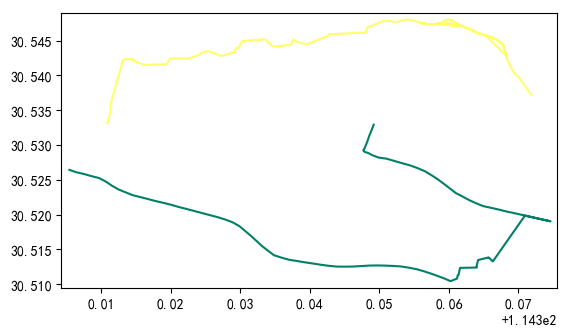

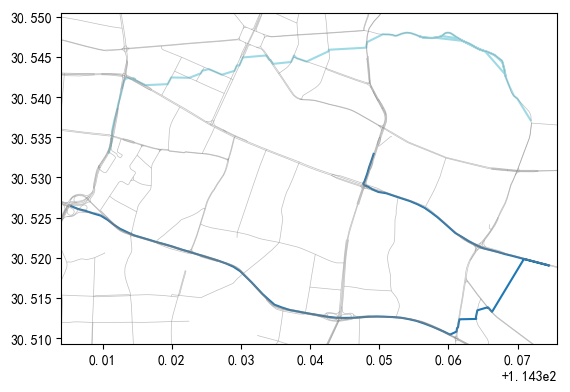

In [34]:
# 画异常轨迹
gdf = gp.GeoDataFrame(new_df_lines[new_df_lines['TID'].isin(tidList)], geometry='geometry')
ax = gdf.plot(column=best_cluster_str,cmap='summer',markersize=1)
minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx - 0.001, maxx + 0.001)
ax.set_ylim(miny - 0.001, maxy + 0.001)

gdf1 = gp.GeoDataFrame(new_df_lines[new_df_lines['TID'].isin(tidList)], geometry='geometry')
ax = gdf1.plot(column='TID',cmap='tab20',markersize=1)
ax.set_xlim(min(new_df['经度']) - 0.001,max(new_df['经度']) + 0.001)
ax.set_ylim(min(new_df['纬度']) - 0.001,max(new_df['纬度']) + 0.001)
# 叠加武汉市路网
road.plot(ax=ax,linewidth=0.5,alpha=0.5,color='grey')

In [35]:
# 将最佳聚类结果值赋给new_df_matched数据 进行进一步异常探测分析 异常行为模式探测与分析
# 使用 pandas 的 merge 方法，将 new_df_lines 的 'cluster2' 列合并到 new_df_matched DataFrame
new_df_cluster = new_df_matched.merge(new_df_lines[['TID', best_cluster_str]], on='TID', how='left')
# 修改列序，使geometry自动生成在最后
order = ['出租车ID', '定位时间', '经度', '纬度', '方向', '速度', '空车/重车', '轨迹ID', 'TID', best_cluster_str, 'geometry']
new_df_cluster = new_df_cluster[order]
new_df_cluster.to_csv('20181110_indexed_cluster.txt',index=False)

In [36]:
# 异常行为模式探测与分析
new_df_cluster = pd.read_csv('20181110_indexed_cluster.txt')

# 两点长度、两点时间和两点区间速度
# 计算每小段轨迹（两点）的长度。可以通过计算相邻定位点之间的距离来实现这一点
# 这里我们使用 geopy 库中的 geodesic 函数，它可以计算两个经纬度坐标之间的地球表面距离
# 将定位时间转换为 datetime 对象
new_df_cluster['定位时间'] = pd.to_datetime(new_df_cluster['定位时间'])

new_df_cluster['两点路程(m)'] = np.nan
new_df_cluster['两点耗时(s)'] = np.nan
new_df_cluster['两点区间速度(km/h)'] = np.nan
for i in range(1, len(new_df_cluster)):
    if new_df_cluster.loc[i, 'TID'] == new_df_cluster.loc[i - 1, 'TID']:
        start = (new_df_cluster.loc[i - 1, '纬度'], new_df_cluster.loc[i - 1, '经度'])
        end = (new_df_cluster.loc[i, '纬度'], new_df_cluster.loc[i, '经度'])
        new_df_cluster.loc[i, '两点路程(m)'] = geodesic(start, end).meters
        new_df_cluster.loc[i, '两点耗时(s)'] = (new_df_cluster.loc[i, '定位时间'] - new_df_cluster.loc[i - 1, '定位时间']).total_seconds()
        new_df_cluster.loc[i, '两点区间速度(km/h)'] = new_df_cluster.loc[i, '两点路程(m)'] / new_df_cluster.loc[i, '两点耗时(s)'] * 3.6
    else:
        new_df_cluster.loc[i, '两点路程(m)'] = 0
        new_df_cluster.loc[i, '两点耗时(s)'] = 0
        new_df_cluster.loc[i, '两点区间速度(km/h)'] = 0

new_df_cluster.loc[0, '两点路程(m)'] = 0
new_df_cluster.loc[0, '两点耗时(s)'] = 0
new_df_cluster.loc[0, '两点区间速度(km/h)'] = 0

# 轨迹分段 先按轨迹整合 轨迹长度、轨迹时间和轨迹速度
trac_grouped = new_df_cluster.groupby('TID').agg({'两点路程(m)': 'sum', '两点耗时(s)': 'sum'}).reset_index()
trac_grouped.columns = ['TID', '轨迹路程(m)', '轨迹耗时(s)']
trac_grouped['轨迹速度(km/h)'] = trac_grouped['轨迹路程(m)'] / trac_grouped['轨迹耗时(s)'] * 3.6
# 将轨迹长度、轨迹时间和轨迹速度合并回原 DataFrame
new_df_cluster = new_df_cluster.merge(trac_grouped, on='TID', how='left')

# 计算每个聚类的平均长度、平均时间和平均速度
cluster_grouped = trac_grouped.merge(new_df_cluster[['TID', best_cluster_str]], on='TID', how='left')
cluster_grouped = cluster_grouped.groupby(best_cluster_str).agg({'轨迹路程(m)': 'mean', '轨迹耗时(s)': 'mean','轨迹速度(km/h)': 'mean'}).reset_index()
cluster_grouped.columns = [best_cluster_str, '聚类平均路程(m)', '聚类平均耗时(s)', '聚类平均速度(km/h)']
# 将每个聚类的平均长度、平均时间和平均速度合并回原 DataFrame
new_df_cluster = new_df_cluster.merge(cluster_grouped, on=best_cluster_str, how='left')

# 计算每个轨迹的长度、区间时间和速度与其所在聚类的平均值的差
new_df_cluster['路程差(m)'] = new_df_cluster['轨迹路程(m)'] - new_df_cluster['聚类平均路程(m)']
new_df_cluster['耗时差(s)'] = new_df_cluster['轨迹耗时(s)'] - new_df_cluster['聚类平均耗时(s)']
new_df_cluster['轨迹速度差(km/h)'] = new_df_cluster['轨迹速度(km/h)'] - new_df_cluster['聚类平均速度(km/h)']

d:\python37\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars
d:\python37\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


In [37]:
# 这里设定聚类平均长度、聚类平均时间为正常
# 行为模式1:长度≤正常轨迹平均长度, 时间≤正常轨迹平均时间。
# 根据该行为模式推断:该轨迹可能是一个经验丰富的出租车司机凭经验选择的一条捷径。利用该方法可以自动发现一些最优路线
# 行为模式2:长度≤正常轨迹平均长度, 时间>正常轨迹平均时间。
# 根据该行为模式推断:可能遇到了拥堵、交通管制等特殊事件。利用该方法可以自动发现一些路段中可能存在的特殊事件
# 行为模式3:长度>正常轨迹平均长度, 时间≤正常轨迹平均时间。
# 根据该行为模式推断:可能是为了赶时间, 为了避开拥堵区域, 而选择了虽然路程较远, 但是可以节约时间的路线。利用该方法可以自动发现一些可以节约时间的路线
# 行为模式4:长度>正常轨迹平均长度, 时间>正常轨迹平均时间。
# 根据该行为模式推断:可能是司机故意绕道。利用该方法可以自动发现一些可能的出租车司机故意绕道行为, 从而为出租车管理提供一些参考
for i in range(0, len(new_df_cluster)):
    if (new_df_cluster.loc[i, '路程差(m)'] <= 0) & (new_df_cluster.loc[i, '耗时差(s)'] <= 0):
        new_df_cluster.loc[i, '模式'] = 1
    elif (new_df_cluster.loc[i, '路程差(m)'] <= 0) & (new_df_cluster.loc[i, '耗时差(s)'] > 0):
        new_df_cluster.loc[i, '模式'] = 2
    elif (new_df_cluster.loc[i, '路程差(m)'] > 0)\
    & (new_df_cluster.loc[i, '耗时差(s)'] <= 0):
        new_df_cluster.loc[i, '模式'] = 3
    else:
        new_df_cluster.loc[i, '模式'] = 4

new_df_cluster.to_csv('20181110_indexed_pattern.txt',index=False)

In [38]:
new_df_cluster[new_df_cluster['TID']==15]

出租车ID                定位时间          经度         纬度     方向    速度 空车/重车  \
1478    633 2018-11-10 07:34:36  114.368699  30.531009  280.0  11.0    重车   
1479    633 2018-11-10 07:34:46  114.368542  30.531023  276.0  16.0    重车   
1480    633 2018-11-10 07:35:02  114.367911  30.531076  272.0  21.0    重车   
1481    633 2018-11-10 07:35:12  114.367265  30.531063  262.0  26.0    重车   
1482    633 2018-11-10 07:35:24  114.366434  30.531189  268.0  38.0    重车   
...     ...                 ...         ...        ...    ...   ...   ...   
1574    633 2018-11-10 07:51:07  114.308669  30.528784  192.0  32.0    重车   
1575    633 2018-11-10 07:51:19  114.307825  30.527779  220.0  36.0    重车   
1576    633 2018-11-10 07:51:29  114.307120  30.527161  238.0  42.0    重车   
1577    633 2018-11-10 07:51:38  114.306148  30.526871  264.0  45.0    重车   
1578    633 2018-11-10 07:51:47  114.305110  30.526471  230.0  43.0    重车   

       轨迹ID  TID  cluster2  ...      轨迹路程(m)  轨迹耗时(s)  轨迹速度(km/h)  \
1478  51021   15         3  ...  9215.639215   1031.0    32.17876   
1479  51021   15         3  ...  9215.639215   1031.0    32.17876   
1480  51021   15         3  ...  9215.639215   1031.0    32.17876   
1481  51021   15         3  ...  9215.639215   1031.0    32.17876   
1482  51021   15         3  ...  9215.639215   1031.0    32.17876   
...     ...  ...       ...  ...          ...      ...         ...   
1574  51021   15         3  ...  9215.639215   1031.0    32.17876   
1575  51021   15         3  ...  9215.639215   1031.0    32.17876   
1576  51021   15         3  ...  9215.639215   1031.0    32.17876   
1577  51021   15         3  ...  9215.639215   1031.0    32.17876   
1578  51021   15         3  ...  9215.639215   1031.0    32.17876   

        聚类平均路程(m)    聚类平均耗时(s)  聚类平均速度(km/h)      路程差(m)    耗时差(s)  \
1478  8844.381463  1040.849246      30.60553  371.257752 -9.849246   
1479  8844.381463  1040.849246      30.60553  371.257752 -9.849246   
1480  8844.381463  1040.849246      30.60553  371.257752 -9.849246   
1481  8844.381463  1040.849246      30.60553  371.257752 -9.849246   
1482  8844.381463  1040.849246      30.60553  371.257752 -9.849246   
...           ...          ...           ...         ...       ...   
1574  8844.381463  1040.849246      30.60553  371.257752 -9.849246   
1575  8844.381463  1040.849246      30.60553  371.257752 -9.849246   
1576  8844.381463  1040.849246      30.60553  371.257752 -9.849246   
1577  8844.381463  1040.849246      30.60553  371.257752 -9.849246   
1578  8844.381463  1040.849246      30.60553  371.257752 -9.849246   

      轨迹速度差(km/h)   模式  
1478      1.57323  3.0  
1479      1.57323  3.0  
1480      1.57323  3.0  
1481      1.57323  3.0  
1482      1.57323  3.0  
...           ...  ...  
1574      1.57323  3.0  
1575      1.57323  3.0  
1576      1.57323  3.0  
1577      1.57323  3.0  
1578      1.57323  3.0  

[101 rows x 24 columns]

In [39]:
new_df_pattern = pd.read_csv('20181110_indexed_pattern.txt')

# 按照"模式"对数据进行分组，并计算每个组中不同的"轨迹ID"的数量
pattern_trace_counts = new_df_pattern.groupby('模式')['轨迹ID'].nunique().tolist()

# 按照"模式"和"轨迹ID"对数据进行分组，并找出每个组中"出租车ID"和"轨迹ID"的唯一值
pattern_trace_taxi = new_df_pattern.groupby(['模式', '轨迹ID'])['出租车ID'].unique().tolist()
# 将每个numpy数组转换为具体的数值
pattern_trace_taxi = [arr.item() for arr in pattern_trace_taxi]

pattern_trace = new_df_pattern.groupby(['模式', '轨迹ID'])['轨迹ID'].unique().tolist()
# 将每个numpy数组转换为具体的数值
pattern_trace = [arr.item() for arr in pattern_trace]

In [40]:
# 统计异常模式
print('模式1（捷径）：')
print('共：',pattern_trace_counts[0],'条轨迹')
print('分别为：')
print('出租车ID',pattern_trace_taxi[0:pattern_trace_counts[0]])
print('轨迹ID',pattern_trace[0:pattern_trace_counts[0]])
print('\n')
print('模式2（特殊事件）：')
print('共：',pattern_trace_counts[1],'条轨迹')
print('分别为：')
print('出租车ID',pattern_trace_taxi[pattern_trace_counts[0]:pattern_trace_counts[0]+pattern_trace_counts[1]])
print('轨迹ID',pattern_trace[pattern_trace_counts[0]:pattern_trace_counts[0]+pattern_trace_counts[1]])
print('\n')
print('模式3（绕路节约时间）：')
print('共：',pattern_trace_counts[2],'条轨迹')
print('分别为：')
print('出租车ID',pattern_trace_taxi[pattern_trace_counts[0]+pattern_trace_counts[1]:pattern_trace_counts[0]+pattern_trace_counts[1]+pattern_trace_counts[2]])
print('轨迹ID',pattern_trace[pattern_trace_counts[0]+pattern_trace_counts[1]:pattern_trace_counts[0]+pattern_trace_counts[1]+pattern_trace_counts[2]])
print('\n')
print('模式4（故意绕道）：')
print('共：',pattern_trace_counts[3],'条轨迹')
print('分别为：')
print('出租车ID',pattern_trace_taxi[pattern_trace_counts[0]+pattern_trace_counts[1]+pattern_trace_counts[2]:pattern_trace_counts[0]+pattern_trace_counts[1]+pattern_trace_counts[2]+pattern_trace_counts[3]])
print('轨迹ID',pattern_trace[pattern_trace_counts[0]+pattern_trace_counts[1]+pattern_trace_counts[2]:pattern_trace_counts[0]+pattern_trace_counts[1]+pattern_trace_counts[2]+pattern_trace_counts[3]])

模式1（捷径）：
共： 8 条轨迹
分别为：
出租车ID [19419, 32349, 35228, 4789, 528, 534, 646, 7107]
轨迹ID [15846, 32809, 34188, 44487, 46966, 47142, 51357, 54235]


模式2（特殊事件）：
共： 3 条轨迹
分别为：
出租车ID [1054, 1257, 7127]
轨迹ID [2206, 6805, 54930]


模式3（绕路节约时间）：
共： 5 条轨迹
分别为：
出租车ID [1271, 18830, 377, 405, 633]
轨迹ID [7224, 13960, 39651, 40890, 51021]


模式4（故意绕道）：
共： 4 条轨迹
分别为：
出租车ID [1321, 31249, 6313, 941]
轨迹ID [8103, 21822, 50949, 64606]


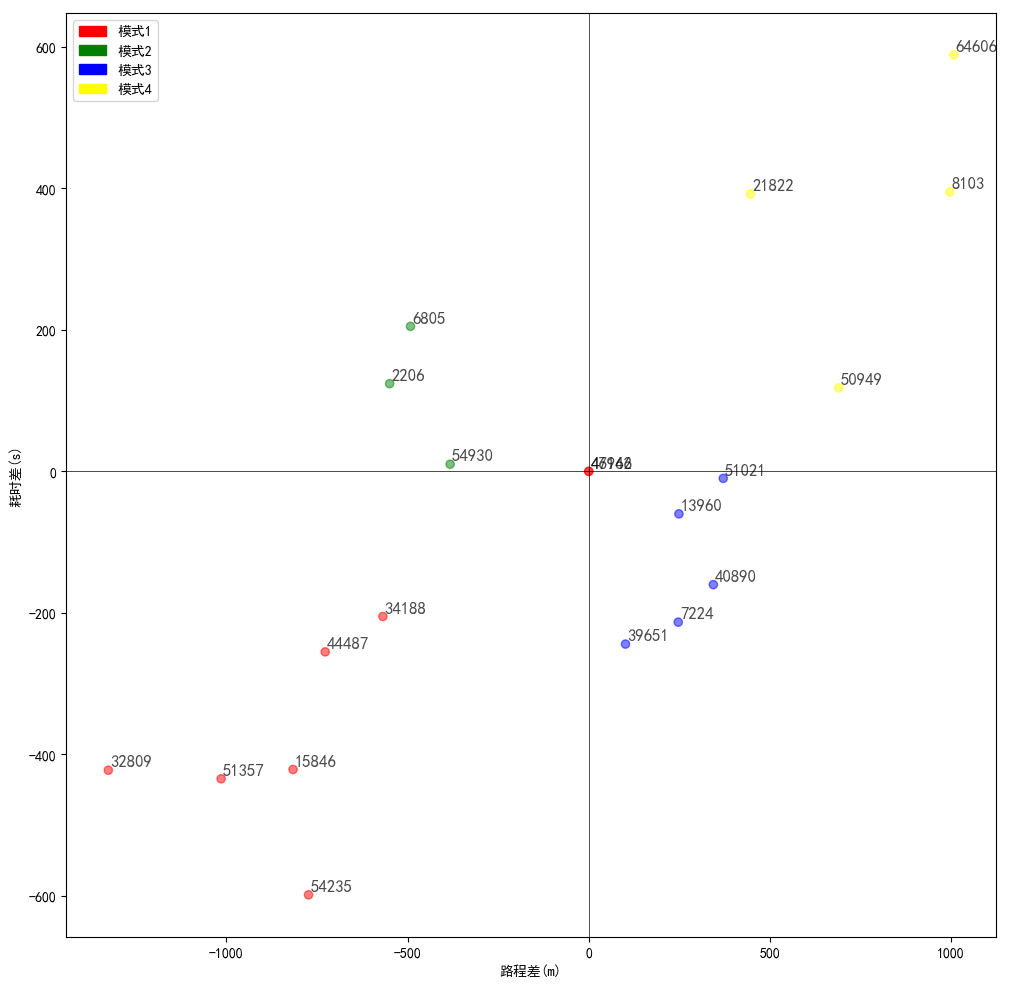

In [43]:
# 选择每条轨迹的第一个点来代表整条轨迹
df_first_point = new_df_pattern.groupby('轨迹ID').first()

# 提取路程差和耗时差作为x轴和y轴
x = df_first_point['路程差(m)']
y = df_first_point['耗时差(s)']
# 设置轨迹点的颜色，分别对应四个模式
colors = df_first_point['模式'].map({1: 'red', 2: 'green', 3: 'blue', 4: 'yellow'})
# 创建散点图
fig, ax = plt.subplots(figsize=(12, 12))
scatter = ax.scatter(x, y, c=colors, alpha=0.5)
# Annotate
for i in range(len(df_first_point)):
    ax.annotate(df_first_point.index[i], (x.iloc[i]+5, y.iloc[i]+5), fontsize=12, alpha=0.7)
# 设置轴标签
ax.set_xlabel('路程差(m)')
ax.set_ylabel('耗时差(s)')
# 在原点绘制x轴和y轴
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
# 创建图例
legend_elements = [mpatches.Patch(color='red', label='模式1'),
                   mpatches.Patch(color='green', label='模式2'),
                   mpatches.Patch(color='blue', label='模式3'),
                   mpatches.Patch(color='yellow', label='模式4')]
ax.legend(handles=legend_elements, loc="upper left")
# 显示图形
plt.show()

In [44]:
# 异常模式可视化 总
cmap = ListedColormap(['red', 'green', 'blue', 'yellow']) # 指定四种颜色分别对应四个模式
gdf = gp.GeoDataFrame(new_df_pattern, geometry=gp.points_from_xy(new_df_pattern['经度'],new_df_pattern['纬度']),crs=4326)
ax = gdf.plot(column='模式',cmap=cmap,markersize=1,figsize=(12,12))
minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx - 0.001, maxx + 0.001)
ax.set_ylim(miny - 0.001, maxy + 0.001)
# 创建一个对应每个模式的图例标签
legend_labels = []
for i in range(4):
    legend_labels.append(mpatches.Patch(color=cmap(i), label=f'Mode {i+1}'))
# 添加图例到图形
ax.legend(handles=legend_labels)

# 叠加武汉市路网
road.plot(ax=ax,linewidth=0.5,alpha=0.5,color='grey')

模式1（捷径）
模式2（特殊事件）
模式3（绕路节约时间）
模式4（故意绕道）


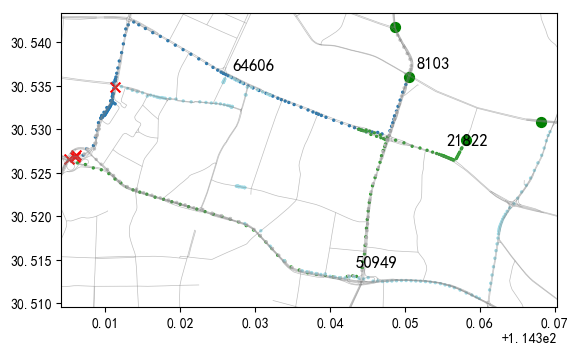

In [46]:
# 异常模式可视化 模式1
print('模式1（捷径）')
fig, ax = plt.subplots()
gdf = gp.GeoDataFrame(new_df_pattern[new_df_pattern['模式']==1], geometry=gp.points_from_xy(new_df_pattern[new_df_pattern['模式']==1]['经度'],new_df_pattern[new_df_pattern['模式']==1]['纬度']),crs=4326)
gdf_start = gdf.groupby('轨迹ID').first()
gdf_end = gdf.groupby('轨迹ID').last()
gdf.plot(ax=ax,column='轨迹ID',cmap='tab20',markersize=2)
# 为起点和终点分别绘图
gdf_start.plot(ax=ax, color='green', marker='o', markersize=50, label='起点') # 绿色圆圈表示起点
gdf_end.plot(ax=ax, color='red', marker='x', markersize=50, label='终点') # 红色叉号表示终点
# 根据轨迹ID在读取排序的顺序与总轨迹数的比例在同一个轨迹ID的系列点的对应比例处标识，例如读取第i条轨迹，总共n条轨迹，则在该轨迹的i/n处标识
# 获取总轨迹数量
n = len(gdf['轨迹ID'].unique())
# 对每个轨迹进行迭代
for i, (track_id, group) in enumerate(gdf.groupby('轨迹ID')):
    # 计算轨迹的长度
    length = len(group)
    # 确定在哪个点添加标签
    label_index = int(length * i / n)
    # 获取该点的位置
    label_point = group.iloc[label_index].geometry
    # 添加标签
    ax.text(label_point.x + 0.001, label_point.y + 0.001, str(track_id), fontsize=12)  # 偏移量可根据实际情况进行调整
minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx - 0.001, maxx + 0.001)
ax.set_ylim(miny - 0.001, maxy + 0.001)

# 叠加武汉市路网
road.plot(ax=ax,linewidth=0.5,alpha=0.5,color='grey')

# 异常模式可视化 模式2
print('模式2（特殊事件）')
fig, ax = plt.subplots()
gdf = gp.GeoDataFrame(new_df_pattern[new_df_pattern['模式']==2], geometry=gp.points_from_xy(new_df_pattern[new_df_pattern['模式']==2]['经度'],new_df_pattern[new_df_pattern['模式']==2]['纬度']),crs=4326)
gdf_start = gdf.groupby('轨迹ID').first()
gdf_end = gdf.groupby('轨迹ID').last()
gdf.plot(ax=ax,column='轨迹ID',cmap='tab20',markersize=2)
# 为起点和终点分别绘图
gdf_start.plot(ax=ax, color='green', marker='o', markersize=50, label='起点') # 绿色圆圈表示起点
gdf_end.plot(ax=ax, color='red', marker='x', markersize=50, label='终点') # 红色叉号表示终点
# 获取总轨迹数量
n = len(gdf['轨迹ID'].unique())
# 对每个轨迹进行迭代
for i, (track_id, group) in enumerate(gdf.groupby('轨迹ID')):
    # 计算轨迹的长度
    length = len(group)
    # 确定在哪个点添加标签
    label_index = int(length * i / n)
    # 获取该点的位置
    label_point = group.iloc[label_index].geometry
    # 添加标签
    ax.text(label_point.x + 0.001, label_point.y + 0.001, str(track_id), fontsize=12)  # 偏移量可根据实际情况进行调整
minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx - 0.001, maxx + 0.001)
ax.set_ylim(miny - 0.001, maxy + 0.001)

# 叠加武汉市路网
road.plot(ax=ax,linewidth=0.5,alpha=0.5,color='grey')

# 异常模式可视化 模式3
print('模式3（绕路节约时间）')
fig, ax = plt.subplots()
gdf = gp.GeoDataFrame(new_df_pattern[new_df_pattern['模式']==3], geometry=gp.points_from_xy(new_df_pattern[new_df_pattern['模式']==3]['经度'],new_df_pattern[new_df_pattern['模式']==3]['纬度']),crs=4326)
gdf_start = gdf.groupby('轨迹ID').first()
gdf_end = gdf.groupby('轨迹ID').last()
gdf.plot(ax=ax,column='轨迹ID',cmap='tab20',markersize=2)
# 为起点和终点分别绘图
gdf_start.plot(ax=ax, color='green', marker='o', markersize=50, label='起点') # 绿色圆圈表示起点
gdf_end.plot(ax=ax, color='red', marker='x', markersize=50, label='终点') # 红色叉号表示终点
# 获取总轨迹数量
n = len(gdf['轨迹ID'].unique())
# 对每个轨迹进行迭代
for i, (track_id, group) in enumerate(gdf.groupby('轨迹ID')):
    # 计算轨迹的长度
    length = len(group)
    # 确定在哪个点添加标签
    label_index = int(length * i / n)
    # 获取该点的位置
    label_point = group.iloc[label_index].geometry
    # 添加标签
    ax.text(label_point.x + 0.001, label_point.y + 0.001, str(track_id), fontsize=12)  # 偏移量可根据实际情况进行调整
minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx - 0.001, maxx + 0.001)
ax.set_ylim(miny - 0.001, maxy + 0.001)

# 叠加武汉市路网
road.plot(ax=ax,linewidth=0.5,alpha=0.5,color='grey')

# 异常模式可视化 模式4
print('模式4（故意绕道）')
fig, ax = plt.subplots()
gdf = gp.GeoDataFrame(new_df_pattern[new_df_pattern['模式']==4], geometry=gp.points_from_xy(new_df_pattern[new_df_pattern['模式']==4]['经度'],new_df_pattern[new_df_pattern['模式']==4]['纬度']),crs=4326)
gdf_start = gdf.groupby('轨迹ID').first()
gdf_end = gdf.groupby('轨迹ID').last()
gdf.plot(ax=ax,column='轨迹ID',cmap='tab20',markersize=2)
# 为起点和终点分别绘图
gdf_start.plot(ax=ax, color='green', marker='o', markersize=50, label='起点') # 绿色圆圈表示起点
gdf_end.plot(ax=ax, color='red', marker='x', markersize=50, label='终点') # 红色叉号表示终点
# 获取总轨迹数量
n = len(gdf['轨迹ID'].unique())
# 对每个轨迹进行迭代
for i, (track_id, group) in enumerate(gdf.groupby('轨迹ID')):
    # 计算轨迹的长度
    length = len(group)
    # 确定在哪个点添加标签
    label_index = int(length * i / n)
    # 获取该点的位置
    label_point = group.iloc[label_index].geometry
    # 添加标签
    ax.text(label_point.x + 0.001, label_point.y + 0.001, str(track_id), fontsize=12)  # 偏移量可根据实际情况进行调整
minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx - 0.001, maxx + 0.001)
ax.set_ylim(miny - 0.001, maxy + 0.001)

# 叠加武汉市路网
road.plot(ax=ax,linewidth=0.5,alpha=0.5,color='grey')

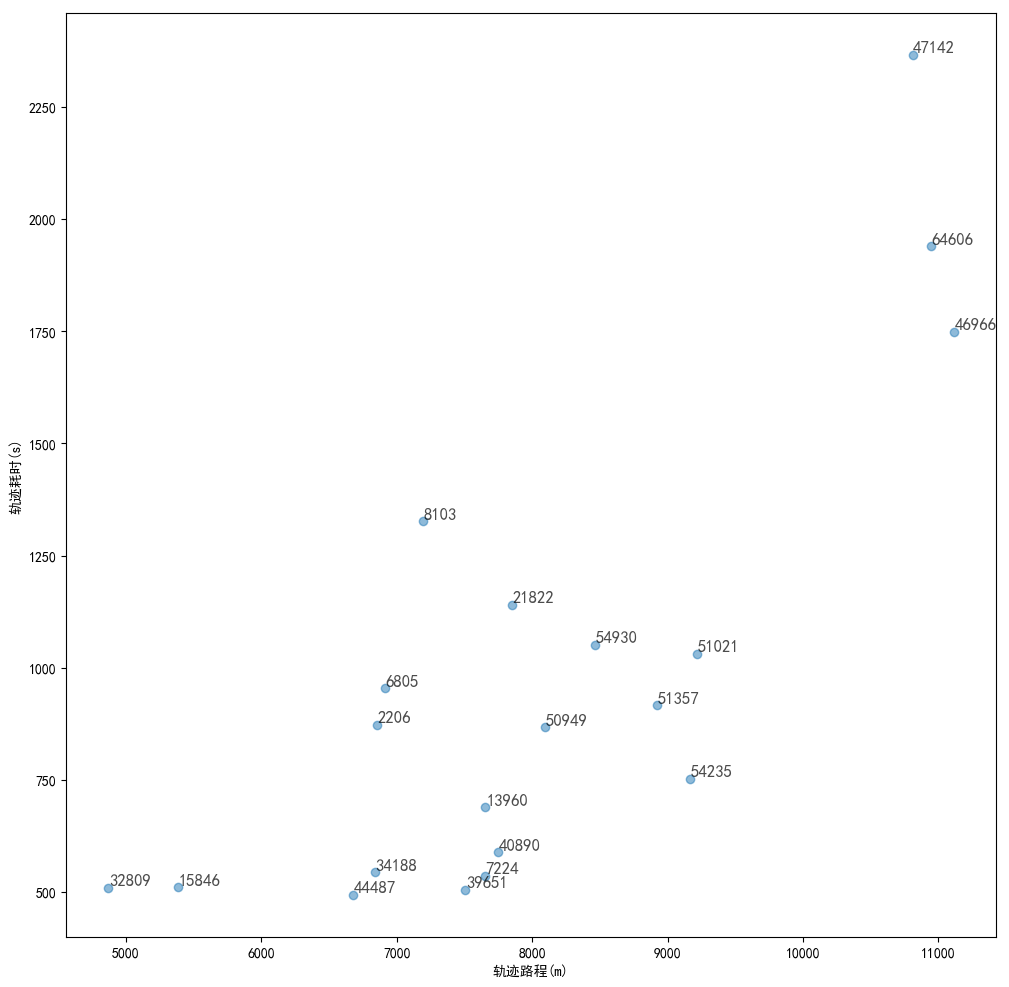

In [49]:
# 轨迹路程为x，轨迹时间为y 轨迹聚类 不基于轨迹间距离
# 换聚类方法和视角分析
fig, ax = plt.subplots(figsize=(12, 12))

x = df_first_point['轨迹路程(m)']
y = df_first_point['轨迹耗时(s)']

ax.scatter(x, y, alpha=0.5)
ax.set_xlabel('轨迹路程(m)')
ax.set_ylabel('轨迹耗时(s)')
# Annotate
for i in range(len(df_first_point)):
    ax.annotate(df_first_point.index[i], (x.iloc[i]+5, y.iloc[i]+5), fontsize=12, alpha=0.7)

plt.show()

In [50]:
# 提取数据
X = df_first_point[['轨迹路程(m)', '轨迹耗时(s)']]
# 数据归一化 将数据归一化以消除不同尺度的影响
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Kmeans聚类
# 要测试的k值的范围
K = range(2, len(X_scaled))
# 计算每个k下的WSS
wss = []
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_scaled)
    wss.append(kmeans.inertia_)
# 找到“Elbow”所在的k
optimal_k = wss.index(min(wss)) + 2
# 使用最优的k进行K-Means聚类
kmeans = KMeans(n_clusters=optimal_k)
kmeans_clusters = kmeans.fit_predict(X_scaled)
# 当数据量小，且数据的分布没有明显的“群”的时候，可能并不存在明显的“拐点”，因此Elbow Method可能会给出一个过大的K值
kmeans = KMeans(3)
kmeans_clusters = kmeans.fit_predict(X_scaled)

# DBSCAN聚类
# 要测试的eps和min_samples的值的范围
eps_values = np.arange(0.1, 1.0, 0.1)
min_samples_values = range(2, len(X_scaled))
# 计算每个参数组合下的Silhouette Score
best_score = -1
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_clusters = dbscan.fit_predict(X_scaled)
        if len(set(dbscan_clusters)) > 1:  # 至少要有两个聚类才能计算Silhouette Score
            score = silhouette_score(X_scaled, dbscan_clusters)
            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples
# 使用最优的eps和min_samples进行DBSCAN聚类
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan_clusters = dbscan.fit_predict(X_scaled)

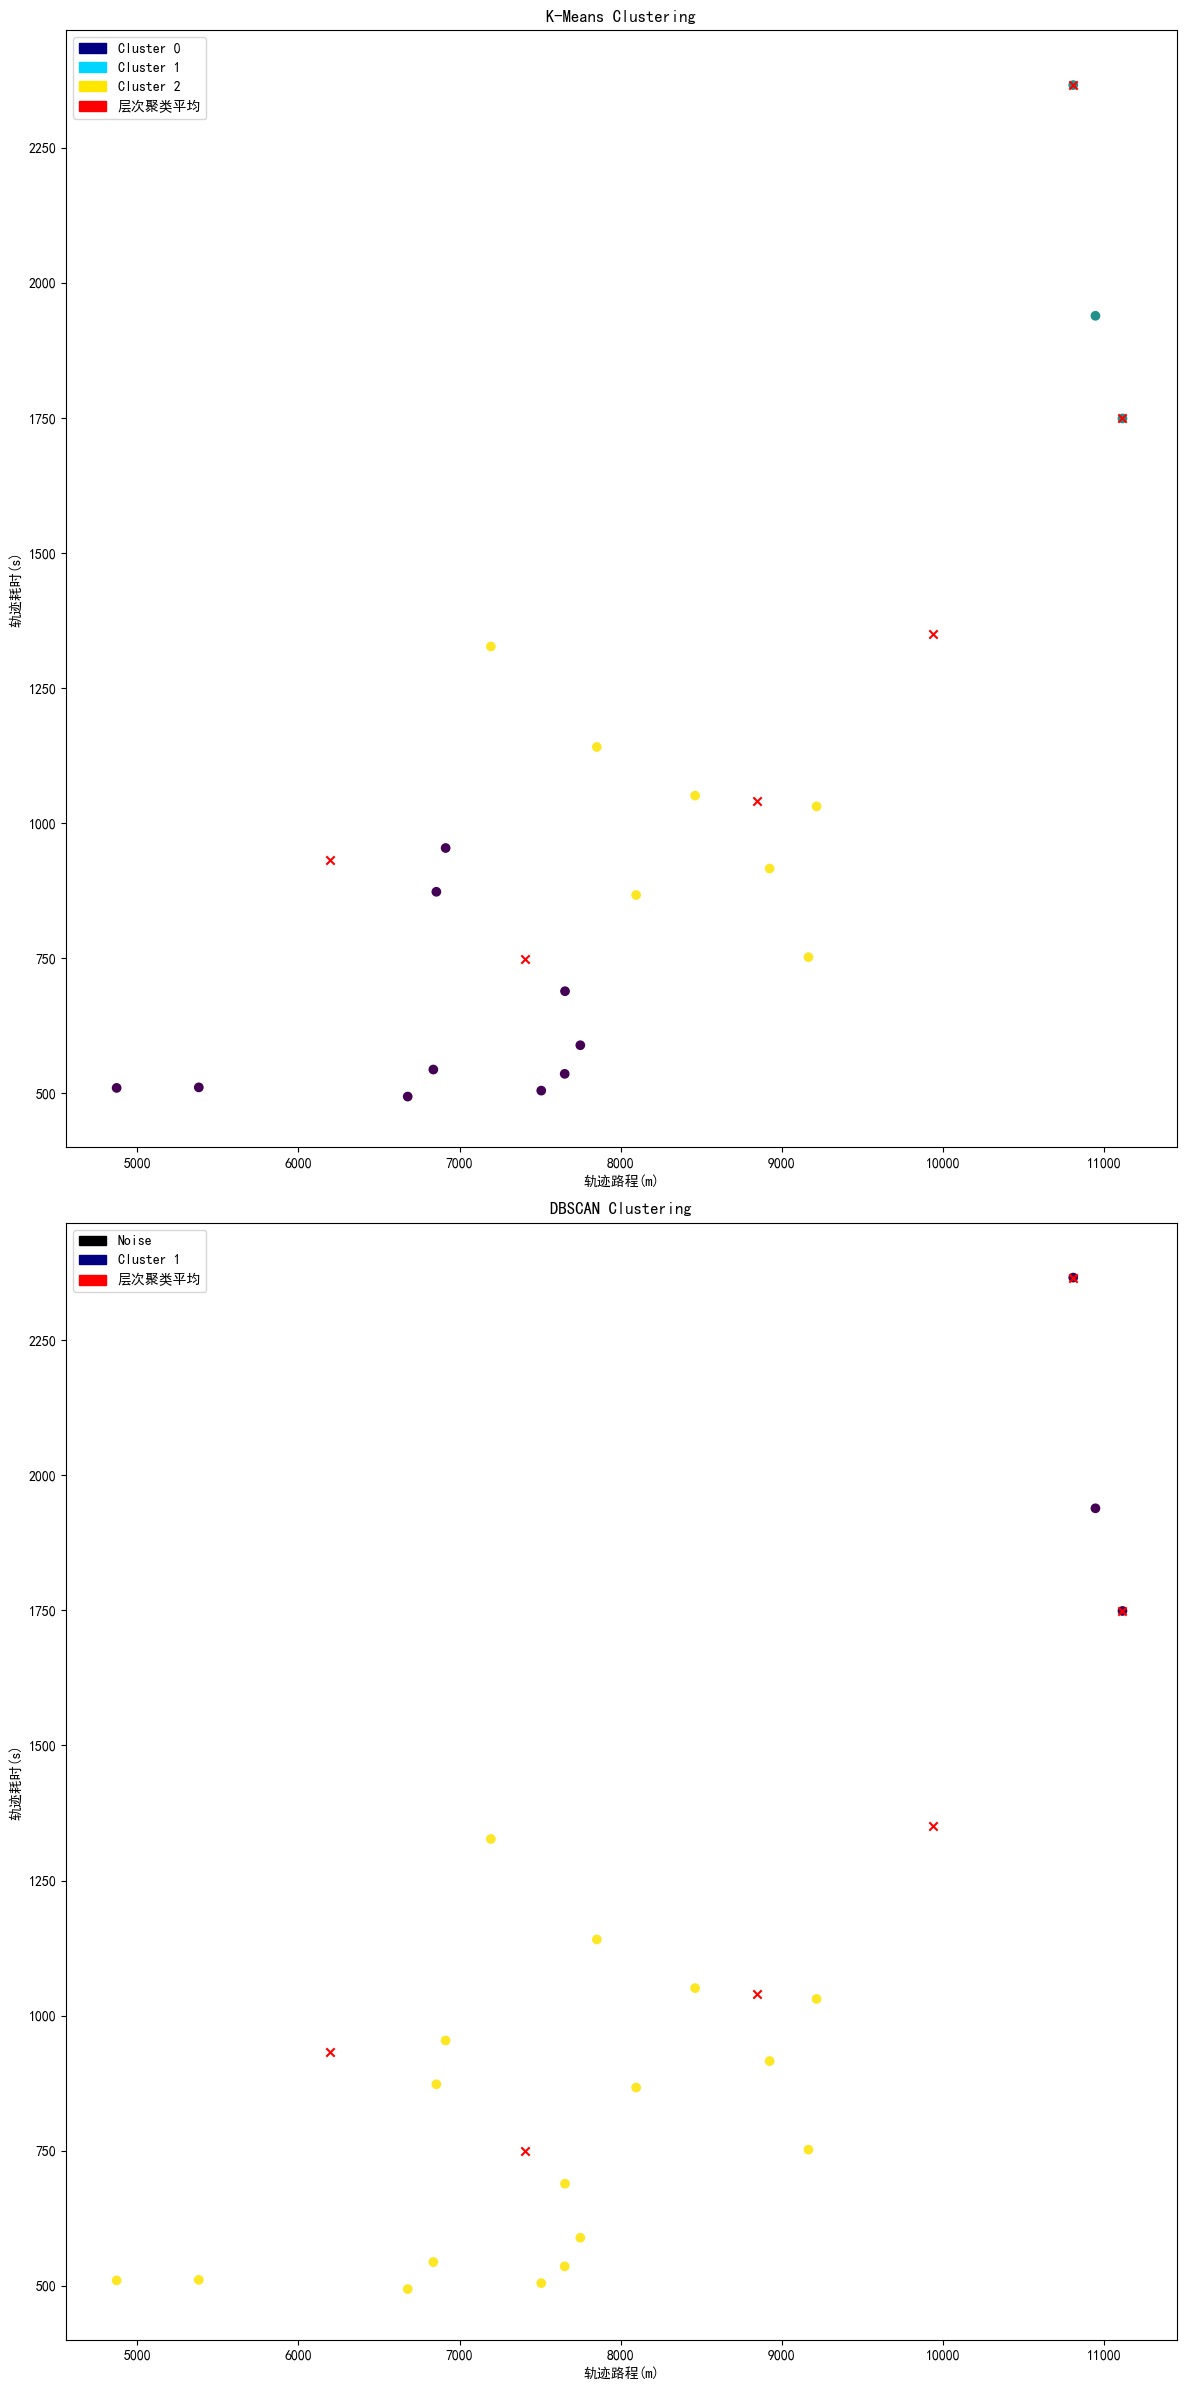

In [51]:
# 提取不重复的'聚类平均路程(m)'和'聚类平均耗时(s)'
unique_points = df_first_point[['聚类平均路程(m)', '聚类平均耗时(s)']].drop_duplicates()

fig, axs = plt.subplots(2, 1, figsize=(12, 24))

# K-Means聚类结果
axs[0].scatter(X['轨迹路程(m)'], X['轨迹耗时(s)'], c=kmeans_clusters)
axs[0].scatter(unique_points['聚类平均路程(m)'], unique_points['聚类平均耗时(s)'], c='red', marker='x')
axs[0].set_title('K-Means Clustering')
axs[0].set_xlabel('轨迹路程(m)')
axs[0].set_ylabel('轨迹耗时(s)')

# 添加K-Means聚类图例
legend_elements_kmeans = [mpatches.Patch(color=plt.cm.jet(i/float(kmeans.n_clusters)), label=f'Cluster {i}') for i in range(kmeans.n_clusters)]
legend_elements_kmeans.append(mpatches.Patch(color='red', label='层次聚类平均'))
axs[0].legend(handles=legend_elements_kmeans, loc="upper left")

# DBSCAN聚类结果
axs[1].scatter(X['轨迹路程(m)'], X['轨迹耗时(s)'], c=dbscan_clusters)
axs[1].scatter(unique_points['聚类平均路程(m)'], unique_points['聚类平均耗时(s)'], c='red', marker='x')
axs[1].set_title('DBSCAN Clustering')
axs[1].set_xlabel('轨迹路程(m)')
axs[1].set_ylabel('轨迹耗时(s)')

# 获取簇的数量（排除噪声点）
n_clusters_dbscan = len(set(dbscan_clusters)) - (1 if -1 in dbscan_clusters else 0)

# 添加DBSCAN聚类图例
legend_elements_dbscan = [mpatches.Patch(color=plt.cm.jet(i/float(n_clusters_dbscan)), label=f'Cluster {i+1}') if i != -1 else mpatches.Patch(color='black', label='Noise') for i in range(-1, n_clusters_dbscan)]
legend_elements_dbscan.append(mpatches.Patch(color='red', label='层次聚类平均'))
axs[1].legend(handles=legend_elements_dbscan, loc="upper left")

plt.tight_layout()
plt.show()

# 4 热点区域空间交互网络

In [66]:
df = pd.read_csv('20181110_0_indexed.txt')

## 4.1 热点区域提取

In [67]:
# 上下车点提取
def get_od_and_trac(df):
    loads = []
    no_loads = []
    pick_up = []
    drop_off = []
    tids = list(df['轨迹ID'].unique())
    for tid in tids:
        sub_df = df[df['轨迹ID']==tid]
        status = sub_df.iloc[0]['空车/重车']
        row1 = sub_df.iloc[0]
        row2 = sub_df.iloc[-1]
        if status=='空车': # 空车轨迹
            no_loads.append(sub_df)
        else: # 重车OD为上下车点
            pick_up.append((row1['经度'],row1['纬度']))
            drop_off.append((row2['经度'],row2['纬度']))
            loads.append(sub_df)
    return loads,no_loads,pick_up,drop_off
loads, no_loads, pick_up, drop_off = get_od_and_trac(df)

(114.0, 114.6)

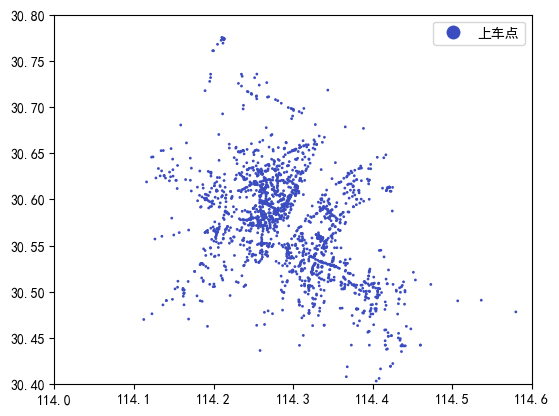

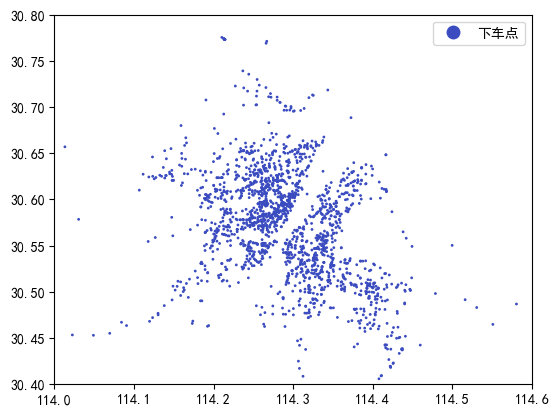

In [78]:
# 可视化上下车点
pick_df = pd.DataFrame(pick_up[:2000])
pick_df.columns = ['经度','纬度']
pick_df['类型'] = '上车点'
drop_df=pd.DataFrame(drop_off[:2000])
drop_df.columns =['经度','纬度']
drop_df['类型'] = '下车点'

gdf1 = gp.GeoDataFrame(pick_df,geometry=gp.points_from_xy(pick_df['经度'],pick_df['纬度']),crs=4326)
ax1=gdf1.plot(column='类型',cmap='coolwarm',legend=True,markersize=1)
ax1.set_ylim([30.4,30.8])
ax1.set_xlim([114.0,114.6])
gdf2 = gp.GeoDataFrame(drop_df,geometry=gp.points_from_xy(drop_df['经度'],drop_df['纬度']),crs=4326)
ax2=gdf2.plot(column='类型',cmap='coolwarm',legend=True,markersize=1)
ax2.set_ylim([30.4,30.8])
ax2.set_xlim([114.0,114.6])

In [69]:
# 汇总上下车点
points_df = pick_df.append(drop_df).reset_index(drop=True)

def doDBSCAN(df,e):
    data = np.array(df.loc[:,['经度','纬度']])
    db = DBSCAN(eps=e).fit(data)
    # 赋值
    df['DB'] = db.labels_
    # 核心
    core=df[df['DB']>-1]
    # 边界
    border=df[df ['DB']==-1]
    # 分别可视化
    gdf_dbscan0 = gp.GeoDataFrame(border,geometry=gp.points_from_xy(border['经度'],border['纬度']),crs=4326)
    ax = gdf_dbscan0.plot(color='black',markersize=0.1)
    gdf_dbscan = gp.GeoDataFrame(core,geometry=gp.points_from_xy(core['经度'],core['纬度']),crs=4326)
    gdf_dbscan.plot(ax=ax,column='DB',legend=True,cmap='coolwarm',markersize=2,figsize=(12,12))
    ax.set_ylim([30.4,30.8])
    ax.set_xlim([114.0,114.6])
    return df

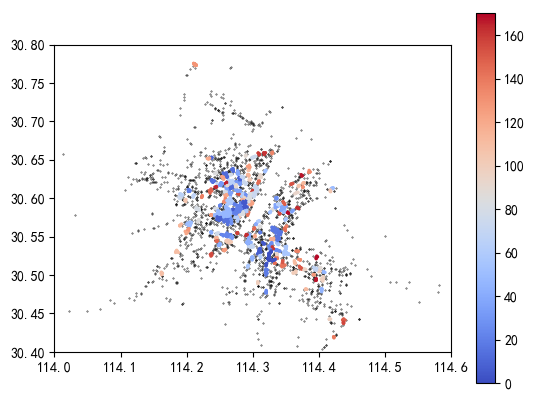

In [70]:
dbscan_point = doDBSCAN(points_df,0.002)

## 4.2 热点交互网络构造

In [71]:
# 构造网络节点
g = nx.Graph()

cluster_nodes = []
N = len(dbscan_point)
for i in range(int(N/2)):
    pick = dbscan_point.iloc[i]['DB']
    drop = dbscan_point.iloc[i+int(N/2)]['DB']
    if pick >-1 and drop >-1 and pick !=drop:
        cluster_nodes.append(pick)
        cluster_nodes.append(drop)
        if g.has_edge(pick,drop):
            w = g[pick][drop]["weight"]
            g[pick][drop]["weight"] = w + 1
        else:
            g.add_edge(pick,drop,weight=1)
cluster_nodes = list(set(cluster_nodes))

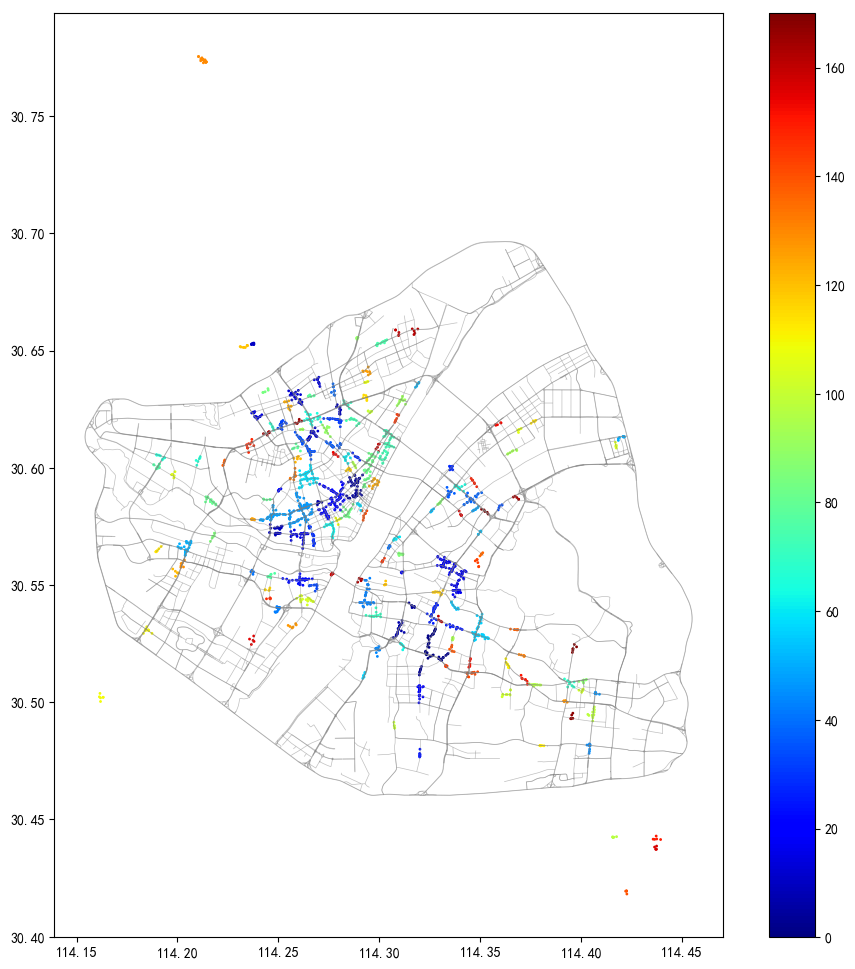

In [72]:
# 空间可视化
core_point = dbscan_point[dbscan_point['DB'].isin(cluster_nodes)]

gdf = gp.GeoDataFrame(core_point,geometry=gp.points_from_xy(core_point['经度'],core_point['纬度']))
ax = gdf.plot(column='DB',cmap='jet',legend=True,markersize=1,figsize=(12,12))
road = gp.read_file('实习一_开发环境配置与轨迹数据初探/data/roads/WHroad.shp')
road.plot(ax=ax,linewidth=0.5,alpha=0.5,color='grey')

In [73]:
# 网络拓扑结构可视化 节点对应所有上下车点中点为节点坐标
pos_dict = {}
for node in g.nodes():
    # 以点的经纬度作为绘制的坐标
    node_df = core_point[core_point['DB']==node]
    pos_dict[node] = (node_df['经度'].mean(),node_df['纬度'].mean())
nx.draw(g,node_size=30,pos=pos_dict,width = 0.1)
plt.show()

## 4.3 热点交互网络分析

In [74]:
# 对比两种中心性的可视化结果并分析差异的原因
# 度中心性
node_deg_centralities = dict( nx.degree_centrality(g))
# 介数中心性
node_bet_centralities = dict( nx.betweenness_centrality(g))

X = [i for i in range(0,len(node_deg_centralities))][1:]
Y = [node_deg_centralities[key] for key in node_deg_centralities][1:] # 设置绘制的数据—空间交互网络节点度中心性
fig = plt.figure()
plt.bar(X,Y,1,color="red")
plt.ylabel("度中心性",fontsize=13)
plt.show()

X = [i for i in range(0,len(node_bet_centralities))][1:]
Y = [node_bet_centralities[key] for key in node_bet_centralities][1:] # 设置绘制的数据—空间交互网络节点度中心性
fig = plt.figure()
plt.bar(X,Y,1,color="blue")
plt.ylabel("介数中心性",fontsize=13)
plt.show()

In [75]:
# 社团划分
def gn_community_detect(G): # 以NetworkX实现封装的社区检测算法为基础，初步探索复杂网络中的社团结构发现与分析方法
    comp = community.greedy_modularity_communities(G,weight='weight')
    graph_community = tuple(sorted(c) for c in comp)
    node_community = {}
    cid = 1
    for c in graph_community:
        for v in c:
            node_community[v] = cid
        cid += 1
    return graph_community,node_community
OD_Community1, node_community = gn_community_detect(g) # 获取社区的划分结果
print('社区划分的个数: '+ str(len(OD_Community1)) + '\n\n各个社区的所属:')
for c in OD_Community1:
    print(c)

社区划分的个数: 7

各个社区的所属:
[1, 2, 3, 4, 7, 16, 17, 18, 24, 25, 26, 40, 43, 44, 49, 50, 53, 54, 55, 57, 58, 60, 64, 71, 87, 88, 93, 94, 100, 104, 106, 118, 120, 128, 143, 144, 146, 149, 153, 156, 163, 170]
[5, 6, 8, 11, 12, 13, 14, 22, 27, 28, 29, 31, 32, 36, 39, 52, 61, 65, 66, 72, 73, 74, 76, 78, 79, 86, 89, 90, 91, 92, 95, 115, 119, 124, 141, 154, 159, 165, 166]
[9, 15, 21, 23, 30, 33, 35, 41, 42, 47, 48, 59, 62, 77, 82, 83, 103, 108, 109, 116, 117, 123, 125, 127, 133, 136, 138, 147, 155]
[0, 10, 19, 34, 45, 46, 56, 63, 69, 96, 97, 98, 99, 101, 102, 111, 112, 132, 137, 139, 140, 142, 150, 151, 152, 157, 161, 168, 169]
[51, 67, 68, 80, 81, 84, 85, 105, 110, 113, 121, 122, 129, 148, 158]
[37, 38, 70, 75, 114, 126, 164]
[107, 130, 145, 160, 162]


In [76]:
# 增加社区字段
core_point['community'] = core_point['DB']
for index,row in core_point.iterrows():
    v = row['community']
    core_point.loc[index,'community'] = node_community[v]

d:\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
d:\python37\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


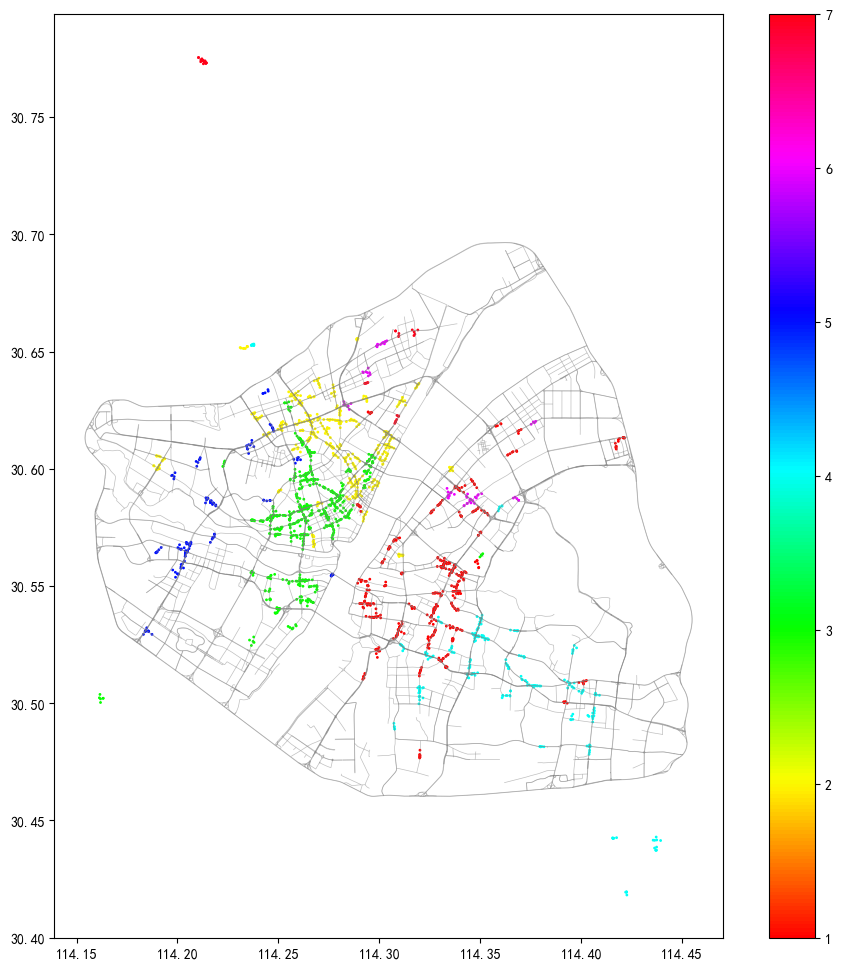

In [77]:
# 热点网络社团空间可视化
community_gdf = gp.GeoDataFrame(core_point,geometry=gp.points_from_xy(core_point['经度'],core_point['纬度']))
track_ax = community_gdf.plot(column='community',cmap='hsv',legend=True,markersize=1,figsize=(12,12)) # 必要的绘图设置
road.plot(ax=track_ax,linewidth=0.5,alpha=0.5,color='grey')